**Forecast vs. Actual Values: Optimizing a Neural Network for Time Series Prediction**

This project focuses on refining a neural network model for time series forecasting by ensuring accurate comparisons between predicted and actual values. The test set remains unchanged, while modifications are made to the data preparation process to prevent truncation of initial values. A validation set is extracted from the training data to improve model evaluation.

To optimize performance, a **hyperparameter tuning approach** is implemented using nested loops, testing different values for **look_back** (sequence length) and **units** (neurons per layer), both ranging from **1 to 12**. The model is trained and evaluated across **three architectures: Simple RNN, LSTM, and GRU**. The best-performing model is selected based on the lowest **RMSE** on the validation set, and the final forecast is visualized against actual values.

🔍 **More details and comments are available at the end of the file.**

**#0 Imports**

In [1]:
# data processing
import numpy as np
import pandas as pd

# transformation – data normalization
from sklearn.preprocessing import MinMaxScaler

# visualization
import matplotlib.pyplot as plt

# neural networks
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import LSTM
from keras.layers import GRU

# model evaluation
from sklearn.metrics import mean_squared_error

**#1 Loading a dataset**

In [2]:
from google.colab import files
uploaded = files.upload()

Saving airline-passengers.csv to airline-passengers.csv


In [3]:
dataset = pd.read_csv('airline-passengers.csv')
dataset['Month'] = pd.to_datetime(dataset['Month'])
dataset.set_index(['Month'], inplace=True)
dataset

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
...,...
1960-08-01,606
1960-09-01,508
1960-10-01,461


**#2 Exploratory data analysis**

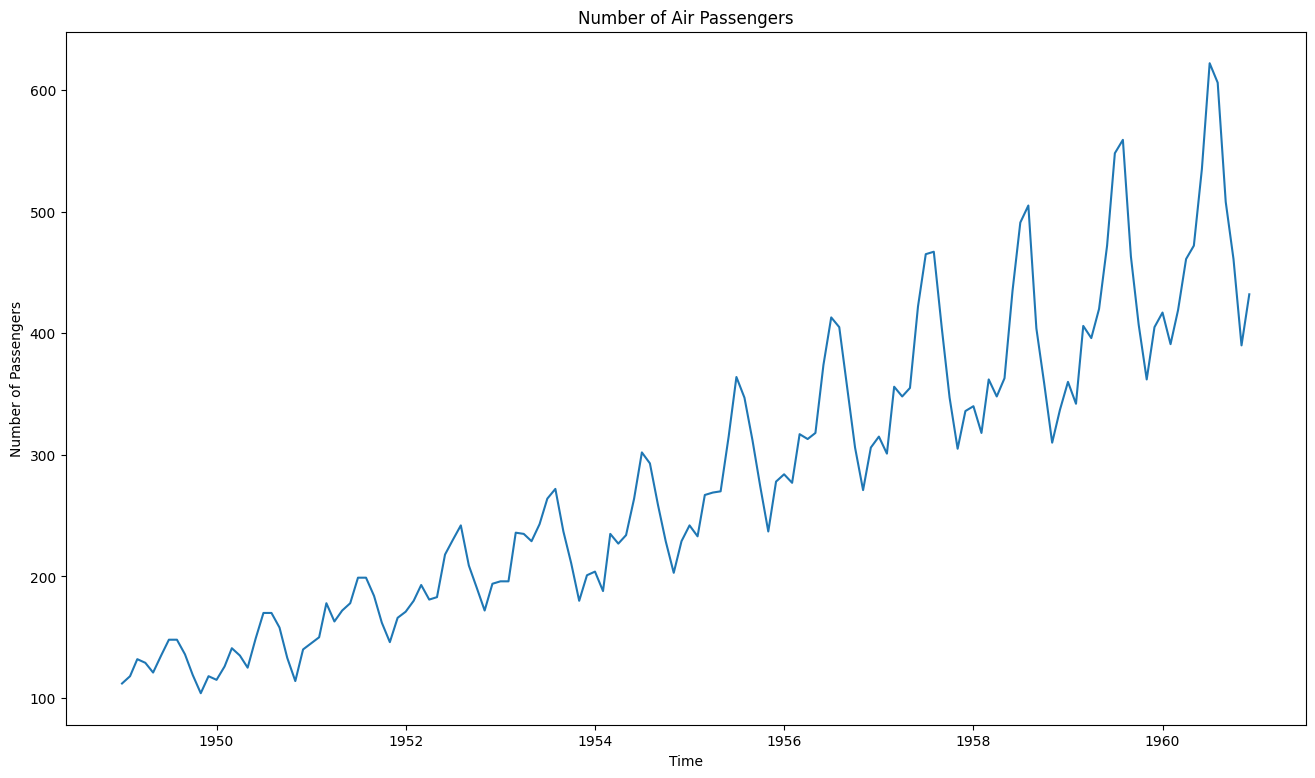

In [4]:
plt.figure(figsize=(16,9))
plt.plot(dataset['Passengers'])
plt.title('Number of Air Passengers')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.show()

**#3 Data preparation**

In [5]:
train_size = int(len(dataset) * 0.60)
val_size = int(len(dataset) * 0.15)
test_size = len(dataset) - train_size - val_size
scaler = MinMaxScaler(feature_range=(0, 1))
look_back = 3                                         # Initial value of look_back

**#4 Function to create training and test collection**

In [6]:
# Function to create datasets
def create_dataset(df, train_size, val_size, lback=look_back, scaler_function=scaler):
    test_size = len(df) - train_size - val_size
    train, val, test = df[0:train_size,:].copy(), df[train_size:train_size+val_size,:].copy(), df[train_size+val_size:len(df),:].copy()

    # Scaling the datasets
    train = scaler_function.fit_transform(train)
    val = scaler_function.transform(val)
    test = scaler_function.transform(test)

    X_train, X_val, X_test, y_train, y_val, y_test = [], [], [], [], [], []

    # Creating the training dataset
    for i in range(len(train)-lback):
        X_train.append(train[i:(i+lback), 0])
        y_train.append(train[i + lback, 0])

    # Creating the validation dataset
    for i in range(len(val)-lback):
        X_val.append(val[i:(i+lback), 0])
        y_val.append(val[i + lback, 0])

    # Creating the test dataset
    for i in range(len(test)):
        if i < lback:
            a = np.concatenate((train[-(lback-i):, 0], test[0:i, 0]))  # Filling with data from the end of the training set
        else:
            a = test[i-lback:i, 0]
        X_test.append(a)
        y_test.append(test[i, 0])

    # Reshaping - changing the shape of the data to (batch_size, look_back, 1)
    X_train, X_val, X_test = np.array(X_train), np.array(X_val), np.array(X_test)
    X_train, X_val, X_test = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)), \
                             np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1)), \
                             np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    y_train, y_val, y_test = np.array(y_train), np.array(y_val), np.array(y_test)

    return X_train, X_val, X_test, y_train, y_val, y_test

**#5 Creating a dataset**

In [7]:
X_train, X_val, X_test, y_train, y_val, y_test = create_dataset(df=np.array(dataset), train_size=train_size, val_size=val_size, lback=look_back)

**#6 Hyperparameter grid**

In [8]:
look_back_range = range(1, 13)   # from 1 to 12
units_range = range(1, 13)       # from 1 to 12

best_rmse = float('inf')
best_model = None
best_params = None

# Loop through all combinations of hyperparameters
for look_back in look_back_range:
    for units in units_range:

        for model_type, ModelClass in zip(["RNN", "LSTM", "GRU"], [SimpleRNN, LSTM, GRU]):
            model = Sequential()
            model.add(ModelClass(units, input_shape=(look_back, 1)))
            model.add(Dense(1))
            model.compile(loss='mean_squared_error', optimizer='adam')

            # Train the model
            print(f"Training {model_type} model - look_back={look_back}, units={units}")
            model.fit(X_train, y_train, epochs=5, batch_size=1, verbose=1, validation_data=(X_val, y_val))

            # Evaluate the model
            prediction_val = model.predict(X_val)
            prediction_val = scaler.inverse_transform(prediction_val)

            rmse_val = mean_squared_error(scaler.inverse_transform(y_val.reshape(-1, 1)), prediction_val) ** 0.5
            if rmse_val < best_rmse:
                best_rmse = rmse_val
                best_model = model
                best_params = (model_type, look_back, units)

Training RNN model - look_back=1, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1387 - val_loss: 0.6162
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0681 - val_loss: 0.4718
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0479 - val_loss: 0.3797
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0351 - val_loss: 0.3292
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0440 - val_loss: 0.3051
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Training LSTM model - look_back=1, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0473 - val_loss: 0.1259
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 - val_loss: 0.0823
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0125 - val_loss: 0.0765
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0699
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Training GRU model - look_back=1, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0207 - val_loss: 0.1335
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0110 - val_loss: 0.1211
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - val_loss: 0.1085
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.1039
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0987
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Training RNN model - look_back=1, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0233 - val_loss: 0.1008
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.1038
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160 - val_loss: 0.1105
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.1081
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 - val_loss: 0.1067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Training LSTM model - look_back=1, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1431 - val_loss: 0.5687
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0527 - val_loss: 0.4051
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0465 - val_loss: 0.3191
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0225 - val_loss: 0.2706
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281 - val_loss: 0.2334


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Training GRU model - look_back=1, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.4160 - val_loss: 1.4892
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1867 - val_loss: 1.0452
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1117 - val_loss: 0.7734
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0622 - val_loss: 0.6232
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0607 - val_loss: 0.5401


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Training RNN model - look_back=1, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7289 - val_loss: 2.1576
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2173 - val_loss: 1.0847
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0909 - val_loss: 0.7508
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0942 - val_loss: 0.6320
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0750 - val_loss: 0.5614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Training LSTM model - look_back=1, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5065 - val_loss: 2.0179
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3006 - val_loss: 1.5310
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2198 - val_loss: 1.2315
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1312 - val_loss: 1.0321
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1321 - val_loss: 0.9037
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Training GRU model - look_back=1, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.6147 - val_loss: 1.9917
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1914 - val_loss: 1.2877
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1279 - val_loss: 0.9470
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1059 - val_loss: 0.7909
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1119 - val_loss: 0.6976
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Training RNN model - look_back=1, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2327 - val_loss: 1.4395
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1005 - val_loss: 1.0735
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0763 - val_loss: 0.9258
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0976 - val_loss: 0.7477
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0619 - val_loss: 0.6269
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Training LSTM model - look_back=1, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0892 - val_loss: 0.2752
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0307 - val_loss: 0.1497
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0230 - val_loss: 0.1155
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0186 - val_loss: 0.0964
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - val_loss: 0.0829
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Training GRU model - look_back=1, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0176 - val_loss: 0.0594
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0084 - val_loss: 0.0533
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0508
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0393
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_loss: 0.0436
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Training RNN model - look_back=1, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0458 - val_loss: 0.0919
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - val_loss: 0.0937
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141 - val_loss: 0.1274
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.1024
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0799
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Training LSTM model - look_back=1, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1900 - val_loss: 0.7529
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0742 - val_loss: 0.4038
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0363 - val_loss: 0.2822
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_loss: 0.2162
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274 - val_loss: 0.1730
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Training GRU model - look_back=1, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0613 - val_loss: 0.1576
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0224 - val_loss: 0.1245
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.1008
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - val_loss: 0.0860
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - val_loss: 0.0824
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Training RNN model - look_back=1, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0905 - val_loss: 0.2563
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - val_loss: 0.1665
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130 - val_loss: 0.1394
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0951
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0831
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Training LSTM model - look_back=1, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1322 - val_loss: 0.3990
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0467 - val_loss: 0.2139
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - val_loss: 0.1513
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - val_loss: 0.1236
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 - val_loss: 0.1230
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Training GRU model - look_back=1, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3404 - val_loss: 0.8821
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0799 - val_loss: 0.4782
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0509 - val_loss: 0.3753
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0425 - val_loss: 0.2643
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0372 - val_loss: 0.2464
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Training RNN model - look_back=1, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0189 - val_loss: 0.1372
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0220 - val_loss: 0.1214
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - val_loss: 0.0943
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - val_loss: 0.1093
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - val_loss: 0.1064
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Training LSTM model - look_back=1, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1043 - val_loss: 0.3400
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0239 - val_loss: 0.1809
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 - val_loss: 0.1618
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 - val_loss: 0.1382
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0140 - val_loss: 0.1073
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Training GRU model - look_back=1, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0381 - val_loss: 0.0818
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0125 - val_loss: 0.0860
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - val_loss: 0.0746
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.0584
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0465
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Training RNN model - look_back=1, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3788 - val_loss: 0.6914
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0539 - val_loss: 0.4248
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344 - val_loss: 0.2984
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282 - val_loss: 0.2228
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 - val_loss: 0.2190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Training LSTM model - look_back=1, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2279 - val_loss: 0.6261
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0834 - val_loss: 0.3194
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0273 - val_loss: 0.2017
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0233 - val_loss: 0.1728
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0275 - val_loss: 0.1424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
Training GRU model - look_back=1, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0464 - val_loss: 0.0945
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - val_loss: 0.0858
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0760
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0124 - val_loss: 0.0521
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0577
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Training RNN model - look_back=1, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0908 - val_loss: 0.1918
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0344 - val_loss: 0.2040
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 - val_loss: 0.1516
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274 - val_loss: 0.1108
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207 - val_loss: 0.1094
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Training LSTM model - look_back=1, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0717 - val_loss: 0.1732
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195 - val_loss: 0.1218
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0944
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0121 - val_loss: 0.0667
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0764
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Training GRU model - look_back=1, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1359 - val_loss: 0.3842
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0399 - val_loss: 0.2719
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268 - val_loss: 0.1955
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0270 - val_loss: 0.1312
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.0971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Training RNN model - look_back=1, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.8689 - val_loss: 1.0708
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1209 - val_loss: 0.6703
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0670 - val_loss: 0.5114
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0543 - val_loss: 0.3999
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 - val_loss: 0.3093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Training LSTM model - look_back=1, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1603 - val_loss: 0.4418
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0398 - val_loss: 0.1945
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0272 - val_loss: 0.1345
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_loss: 0.1199
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - val_loss: 0.0994
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Training GRU model - look_back=1, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0874 - val_loss: 0.1575
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0187 - val_loss: 0.1004
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0187 - val_loss: 0.1035
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0112 - val_loss: 0.0530
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0168 - val_loss: 0.0663
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Training RNN model - look_back=1, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1685 - val_loss: 0.1119
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 - val_loss: 0.0978
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0551
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0716
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0404
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Training LSTM model - look_back=1, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0789 - val_loss: 0.1185
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - val_loss: 0.0901
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - val_loss: 0.0765
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - val_loss: 0.0539
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.0616
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Training GRU model - look_back=1, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1882 - val_loss: 0.4709
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0619 - val_loss: 0.3438
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0367 - val_loss: 0.2162
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0273 - val_loss: 0.1600
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0207 - val_loss: 0.1082
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Training RNN model - look_back=1, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0294 - val_loss: 0.0841
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0717
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0636
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0061 - val_loss: 0.0388
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.0470
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Training LSTM model - look_back=1, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1303 - val_loss: 0.2733
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316 - val_loss: 0.1651
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0256 - val_loss: 0.1182
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0194 - val_loss: 0.0990
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 - val_loss: 0.0736
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Training GRU model - look_back=1, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1914 - val_loss: 0.3594
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288 - val_loss: 0.2030
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0238 - val_loss: 0.1594
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0287 - val_loss: 0.1238
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0197 - val_loss: 0.1049
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Training RNN model - look_back=2, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0112 - val_loss: 0.0409
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0448
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0432
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0087 - val_loss: 0.0443
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0079 - val_loss: 0.0468
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Training LSTM model - look_back=2, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2596 - val_loss: 1.1016
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1669 - val_loss: 0.8801
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0943 - val_loss: 0.7331
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0738 - val_loss: 0.6310
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0564 - val_loss: 0.5407
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Training GRU model - look_back=2, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1974 - val_loss: 0.9546
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1094 - val_loss: 0.7014
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0758 - val_loss: 0.5220
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0651 - val_loss: 0.4486
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0719 - val_loss: 0.3975
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Training RNN model - look_back=2, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2886 - val_loss: 1.3321
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1071 - val_loss: 0.9918
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0763 - val_loss: 0.8408
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0659 - val_loss: 0.7337
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0489 - val_loss: 0.6753
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step
Training LSTM model - look_back=2, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1866 - val_loss: 0.9710
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1586 - val_loss: 0.8130
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1118 - val_loss: 0.6933
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0620 - val_loss: 0.5763
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0620 - val_loss: 0.4737
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Training GRU model - look_back=2, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.7739 - val_loss: 2.6859
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.3330 - val_loss: 2.0004
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2155 - val_loss: 1.5909
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1520 - val_loss: 1.2919
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1195 - val_loss: 1.1161
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Training RNN model - look_back=2, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.2711 - val_loss: 1.2391
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1224 - val_loss: 0.7488
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0933 - val_loss: 0.5715
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0441 - val_loss: 0.5103
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - val_loss: 0.4213
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Training LSTM model - look_back=2, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1491 - val_loss: 0.6240
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0666 - val_loss: 0.3732
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0274 - val_loss: 0.2726
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0262 - val_loss: 0.2294
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0276 - val_loss: 0.1939
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Training GRU model - look_back=2, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1352 - val_loss: 0.4637
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0500 - val_loss: 0.2906
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 - val_loss: 0.2294
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - val_loss: 0.1987
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0260 - val_loss: 0.1815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Training RNN model - look_back=2, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0313 - val_loss: 0.0911
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0150 - val_loss: 0.1018
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.1077
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0888
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - val_loss: 0.1110
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Training LSTM model - look_back=2, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1100 - val_loss: 0.3671
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0382 - val_loss: 0.1863
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - val_loss: 0.1423
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - val_loss: 0.1186
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.0924
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Training GRU model - look_back=2, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2535 - val_loss: 0.9898
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0948 - val_loss: 0.5932
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0530 - val_loss: 0.4196
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0472 - val_loss: 0.3729
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0494 - val_loss: 0.3424
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Training RNN model - look_back=2, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5945 - val_loss: 1.5720
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1086 - val_loss: 0.9488
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1015 - val_loss: 0.7581
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0762 - val_loss: 0.6498
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0491 - val_loss: 0.5387
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Training LSTM model - look_back=2, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2778 - val_loss: 0.8247
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0908 - val_loss: 0.4481
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0455 - val_loss: 0.2962
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0330 - val_loss: 0.2342
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 - val_loss: 0.2047
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Training GRU model - look_back=2, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0625 - val_loss: 0.1502
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164 - val_loss: 0.1097
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0878
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.0744
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0105 - val_loss: 0.0632
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Training RNN model - look_back=2, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2707 - val_loss: 0.3866
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - val_loss: 0.1964
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 - val_loss: 0.1603
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - val_loss: 0.1428
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 - val_loss: 0.1201
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Training LSTM model - look_back=2, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1690 - val_loss: 0.6042
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0529 - val_loss: 0.3713
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0406 - val_loss: 0.2823
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0353 - val_loss: 0.2594
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0236 - val_loss: 0.1997
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Training GRU model - look_back=2, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2239 - val_loss: 0.6539
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0505 - val_loss: 0.3875
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299 - val_loss: 0.3178
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0363 - val_loss: 0.2553
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295 - val_loss: 0.2135
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Training RNN model - look_back=2, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0208 - val_loss: 0.1904
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193 - val_loss: 0.1458
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_loss: 0.1178
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0173 - val_loss: 0.1254
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - val_loss: 0.1190
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Training LSTM model - look_back=2, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1499 - val_loss: 0.3860
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0436 - val_loss: 0.1943
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0164 - val_loss: 0.1520
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190 - val_loss: 0.1123
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0988
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Training GRU model - look_back=2, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0416 - val_loss: 0.1106
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0190 - val_loss: 0.0878
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0158 - val_loss: 0.0711
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0108 - val_loss: 0.0834
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0546
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Training RNN model - look_back=2, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0399 - val_loss: 0.1171
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0158 - val_loss: 0.1233
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0180 - val_loss: 0.0865
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0680
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0113 - val_loss: 0.0725
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Training LSTM model - look_back=2, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2035 - val_loss: 0.6384
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0696 - val_loss: 0.3123
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316 - val_loss: 0.2293
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0346 - val_loss: 0.1927
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0272 - val_loss: 0.1393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Training GRU model - look_back=2, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3701 - val_loss: 1.1675
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1019 - val_loss: 0.5646
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0595 - val_loss: 0.4227
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0395 - val_loss: 0.3208
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0339 - val_loss: 0.2288
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Training RNN model - look_back=2, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0114 - val_loss: 0.0662
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0805
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0574
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.0490
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.0348
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Training LSTM model - look_back=2, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1463 - val_loss: 0.5470
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0596 - val_loss: 0.3197
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0409 - val_loss: 0.2300
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243 - val_loss: 0.1808
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - val_loss: 0.1337
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Training GRU model - look_back=2, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0920 - val_loss: 0.1718
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0204 - val_loss: 0.1249
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0169 - val_loss: 0.0758
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0639
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 - val_loss: 0.0505
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Training RNN model - look_back=2, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5559 - val_loss: 0.8567
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0586 - val_loss: 0.4562
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0341 - val_loss: 0.3180
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0356 - val_loss: 0.2236
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392 - val_loss: 0.2053
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
Training LSTM model - look_back=2, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1272 - val_loss: 0.4808
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0483 - val_loss: 0.2278
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0273 - val_loss: 0.2001
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251 - val_loss: 0.1564
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 - val_loss: 0.1277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Training GRU model - look_back=2, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1555 - val_loss: 0.3125
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0261 - val_loss: 0.1705
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - val_loss: 0.1354
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171 - val_loss: 0.0994
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0177 - val_loss: 0.0809
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Training RNN model - look_back=2, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0742 - val_loss: 0.2345
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0389 - val_loss: 0.1890
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0222 - val_loss: 0.1492
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - val_loss: 0.1496
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.1244
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Training LSTM model - look_back=2, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2018 - val_loss: 0.4666
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0400 - val_loss: 0.1799
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0252 - val_loss: 0.1650
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0241 - val_loss: 0.1345
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - val_loss: 0.0968
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Training GRU model - look_back=2, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1746 - val_loss: 0.3837
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0341 - val_loss: 0.2287
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0269 - val_loss: 0.1818
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0234 - val_loss: 0.1590
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237 - val_loss: 0.0944
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Training RNN model - look_back=2, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0263 - val_loss: 0.0975
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0789
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0882
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 - val_loss: 0.0565
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0701
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Training LSTM model - look_back=2, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1507 - val_loss: 0.3879
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0376 - val_loss: 0.1733
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0216 - val_loss: 0.1364
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 - val_loss: 0.1212
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0143 - val_loss: 0.0784
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Training GRU model - look_back=2, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0849 - val_loss: 0.1671
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0220 - val_loss: 0.1428
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0203 - val_loss: 0.1043
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0649
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Training RNN model - look_back=3, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1033 - val_loss: 0.0774
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0358 - val_loss: 0.1143
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0273 - val_loss: 0.1367
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 - val_loss: 0.1517
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - val_loss: 0.1582
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Training LSTM model - look_back=3, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2786 - val_loss: 1.2182
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1879 - val_loss: 1.0272
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2136 - val_loss: 0.8882
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1061 - val_loss: 0.7863
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0910 - val_loss: 0.7060
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Training GRU model - look_back=3, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0441 - val_loss: 0.2438
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - val_loss: 0.2055
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - val_loss: 0.1889
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - val_loss: 0.1711
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - val_loss: 0.1550
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Training RNN model - look_back=3, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4470 - val_loss: 1.5493
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2394 - val_loss: 1.0952
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1479 - val_loss: 0.8638
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0787 - val_loss: 0.7164
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0837 - val_loss: 0.6110
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Training LSTM model - look_back=3, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.3862 - val_loss: 1.4836
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.2215 - val_loss: 1.1444
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1204 - val_loss: 0.9211
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1091 - val_loss: 0.7749
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0641 - val_loss: 0.6789
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Training GRU model - look_back=3, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1802 - val_loss: 0.7928
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1049 - val_loss: 0.5555
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0530 - val_loss: 0.4169
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0367 - val_loss: 0.3483
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0356 - val_loss: 0.3038
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Training RNN model - look_back=3, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1582 - val_loss: 0.3315
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - val_loss: 0.2081
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0279 - val_loss: 0.1811
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0167 - val_loss: 0.1604
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0204 - val_loss: 0.1444
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Training LSTM model - look_back=3, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1065 - val_loss: 0.4576
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386 - val_loss: 0.2818
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259 - val_loss: 0.2117
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0245 - val_loss: 0.1838
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0168 - val_loss: 0.1473
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Training GRU model - look_back=3, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1302 - val_loss: 0.5773
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0604 - val_loss: 0.3765
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0443 - val_loss: 0.3022
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0243 - val_loss: 0.2612
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 - val_loss: 0.2330
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Training RNN model - look_back=3, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1154 - val_loss: 0.5607
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0490 - val_loss: 0.4266
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0269 - val_loss: 0.3522
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - val_loss: 0.2763
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.2606
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Training LSTM model - look_back=3, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2342 - val_loss: 0.7743
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0754 - val_loss: 0.3833
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0282 - val_loss: 0.2358
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0336 - val_loss: 0.2154
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0265 - val_loss: 0.1732
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Training GRU model - look_back=3, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0538 - val_loss: 0.1678
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0198 - val_loss: 0.1247
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0132 - val_loss: 0.0973
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0123 - val_loss: 0.0793
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0675
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Training RNN model - look_back=3, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.8018 - val_loss: 3.9671
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4946 - val_loss: 1.7207
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1431 - val_loss: 1.0067
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1480 - val_loss: 0.8523
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1049 - val_loss: 0.6456
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Training LSTM model - look_back=3, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1050 - val_loss: 0.3180
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0231 - val_loss: 0.1610
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - val_loss: 0.1273
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0179 - val_loss: 0.0987
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - val_loss: 0.0936
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Training GRU model - look_back=3, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2168 - val_loss: 0.8850
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0846 - val_loss: 0.4965
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0515 - val_loss: 0.3847
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0434 - val_loss: 0.3172
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0399 - val_loss: 0.2980
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Training RNN model - look_back=3, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4364 - val_loss: 0.0447
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0370 - val_loss: 0.0293
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - val_loss: 0.0416
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 - val_loss: 0.0481
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0619
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Training LSTM model - look_back=3, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.3862 - val_loss: 1.5618
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1982 - val_loss: 0.9798
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1118 - val_loss: 0.6764
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0815 - val_loss: 0.5192
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0519 - val_loss: 0.4321
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
Training GRU model - look_back=3, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2250 - val_loss: 0.6043
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0545 - val_loss: 0.3355
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0445 - val_loss: 0.2576
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0299 - val_loss: 0.1930
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0280 - val_loss: 0.1222
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Training RNN model - look_back=3, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1159 - val_loss: 0.1259
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0140 - val_loss: 0.0767
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.0593
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0453
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.0326
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Training LSTM model - look_back=3, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2192 - val_loss: 0.7920
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0889 - val_loss: 0.3741
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0386 - val_loss: 0.2464
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0248 - val_loss: 0.2112
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0230 - val_loss: 0.1556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Training GRU model - look_back=3, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1267 - val_loss: 0.2282
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266 - val_loss: 0.1690
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191 - val_loss: 0.1104
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168 - val_loss: 0.0941
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168 - val_loss: 0.0857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Training RNN model - look_back=3, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0154 - val_loss: 0.1225
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0078 - val_loss: 0.1357
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0960
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.1006
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0100 - val_loss: 0.0694
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Training LSTM model - look_back=3, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2510 - val_loss: 0.7624
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0912 - val_loss: 0.3481
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0371 - val_loss: 0.2109
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.1683
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 - val_loss: 0.1393
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Training GRU model - look_back=3, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3230 - val_loss: 0.8487
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0641 - val_loss: 0.4561
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0494 - val_loss: 0.3415
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0403 - val_loss: 0.2995
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0338 - val_loss: 0.1834
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Training RNN model - look_back=3, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3596 - val_loss: 0.3343
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0513 - val_loss: 0.2484
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 - val_loss: 0.1600
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - val_loss: 0.0882
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - val_loss: 0.1352
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Training LSTM model - look_back=3, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1325 - val_loss: 0.2982
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0251 - val_loss: 0.1576
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0208 - val_loss: 0.1260
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0160 - val_loss: 0.1148
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0159 - val_loss: 0.0895
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Training GRU model - look_back=3, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2653 - val_loss: 0.7460
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0469 - val_loss: 0.3611
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0369 - val_loss: 0.2667
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0313 - val_loss: 0.2017
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0268 - val_loss: 0.1800
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Training RNN model - look_back=3, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0324 - val_loss: 0.0634
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.0576
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0273
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0212
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0074 - val_loss: 0.0330
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Training LSTM model - look_back=3, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1211 - val_loss: 0.2700
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249 - val_loss: 0.1408
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0215 - val_loss: 0.1324
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - val_loss: 0.0961
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0142 - val_loss: 0.0739
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Training GRU model - look_back=3, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1650 - val_loss: 0.4419
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0353 - val_loss: 0.2260
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323 - val_loss: 0.1830
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - val_loss: 0.1756
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237 - val_loss: 0.1106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Training RNN model - look_back=3, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0785 - val_loss: 0.2556
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0295 - val_loss: 0.1522
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0289 - val_loss: 0.1648
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301 - val_loss: 0.1160
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0214 - val_loss: 0.1204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Training LSTM model - look_back=3, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0951 - val_loss: 0.1904
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_loss: 0.1137
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.1019
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - val_loss: 0.0899
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0119 - val_loss: 0.0789
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Training GRU model - look_back=3, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1460 - val_loss: 0.1785
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0235 - val_loss: 0.1253
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0223 - val_loss: 0.1020
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0195 - val_loss: 0.0976
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - val_loss: 0.0882
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Training RNN model - look_back=3, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0186 - val_loss: 0.0988
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144 - val_loss: 0.1067
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.0688
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104 - val_loss: 0.0604
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0820
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Training LSTM model - look_back=3, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1218 - val_loss: 0.3163
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0340 - val_loss: 0.1680
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - val_loss: 0.1166
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 - val_loss: 0.0911
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.0733
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Training GRU model - look_back=3, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1417 - val_loss: 0.3391
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0317 - val_loss: 0.2174
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0278 - val_loss: 0.1563
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0218 - val_loss: 0.1144
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - val_loss: 0.0845
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Training RNN model - look_back=4, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2383 - val_loss: 0.0772
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1023 - val_loss: 0.0439
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0561 - val_loss: 0.0354
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0469 - val_loss: 0.0338
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 - val_loss: 0.0347
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Training LSTM model - look_back=4, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0605 - val_loss: 0.4457
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0316 - val_loss: 0.3754
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0229 - val_loss: 0.3443
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - val_loss: 0.3174
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0164 - val_loss: 0.2971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Training GRU model - look_back=4, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1222 - val_loss: 0.6434
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0776 - val_loss: 0.4929
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0543 - val_loss: 0.4048
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0280 - val_loss: 0.3573
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0438 - val_loss: 0.3279
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Training RNN model - look_back=4, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2373 - val_loss: 0.7737
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0899 - val_loss: 0.4448
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0460 - val_loss: 0.3503
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0358 - val_loss: 0.3169
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0367 - val_loss: 0.2846
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Training LSTM model - look_back=4, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3660 - val_loss: 1.4437
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1640 - val_loss: 0.9916
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1197 - val_loss: 0.6691
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0734 - val_loss: 0.5124
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0503 - val_loss: 0.4196
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Training GRU model - look_back=4, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1621 - val_loss: 0.5901
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0438 - val_loss: 0.3801
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0299 - val_loss: 0.2892
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0302 - val_loss: 0.2508
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0243 - val_loss: 0.2216
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Training RNN model - look_back=4, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1583 - val_loss: 0.5618
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - val_loss: 0.3433
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0392 - val_loss: 0.3016
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0371 - val_loss: 0.2800
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0477 - val_loss: 0.2533
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Training LSTM model - look_back=4, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1303 - val_loss: 0.4829
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0392 - val_loss: 0.2947
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0240 - val_loss: 0.2157
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_loss: 0.1778
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0185 - val_loss: 0.1605
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Training GRU model - look_back=4, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1656 - val_loss: 0.5859
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0379 - val_loss: 0.3476
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0404 - val_loss: 0.3078
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0386 - val_loss: 0.2548
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0286 - val_loss: 0.1924
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Training RNN model - look_back=4, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3207 - val_loss: 0.6212
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0609 - val_loss: 0.3747
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0506 - val_loss: 0.2646
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0323 - val_loss: 0.1747
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0339 - val_loss: 0.1429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Training LSTM model - look_back=4, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2714 - val_loss: 0.8551
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1118 - val_loss: 0.4906
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0514 - val_loss: 0.3293
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0493 - val_loss: 0.2434
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0322 - val_loss: 0.2248
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Training GRU model - look_back=4, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0761 - val_loss: 0.2173
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266 - val_loss: 0.1547
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 - val_loss: 0.1210
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0170 - val_loss: 0.0875
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0168 - val_loss: 0.0853
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Training RNN model - look_back=4, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0340 - val_loss: 0.1671
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.1273
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.1228
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.1148
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0069 - val_loss: 0.0945
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Training LSTM model - look_back=4, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1950 - val_loss: 0.7697
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0668 - val_loss: 0.4377
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0425 - val_loss: 0.2893
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0369 - val_loss: 0.2363
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0279 - val_loss: 0.1850
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Training GRU model - look_back=4, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2179 - val_loss: 0.8483
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0699 - val_loss: 0.4860
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0449 - val_loss: 0.3625
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0329 - val_loss: 0.3228
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0330 - val_loss: 0.2718
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Training RNN model - look_back=4, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1214 - val_loss: 0.2319
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0245 - val_loss: 0.1270
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0234 - val_loss: 0.1081
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - val_loss: 0.0766
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130 - val_loss: 0.0649
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Training LSTM model - look_back=4, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1520 - val_loss: 0.4790
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0531 - val_loss: 0.2360
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0285 - val_loss: 0.1552
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0245 - val_loss: 0.1381
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_loss: 0.1115
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Training GRU model - look_back=4, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3598 - val_loss: 1.1100
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0994 - val_loss: 0.5783
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0485 - val_loss: 0.4035
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0416 - val_loss: 0.3286
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0452 - val_loss: 0.2970
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Training RNN model - look_back=4, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1300 - val_loss: 0.1500
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 - val_loss: 0.0987
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0732
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0612
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0083 - val_loss: 0.0592
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Training LSTM model - look_back=4, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1155 - val_loss: 0.2558
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0288 - val_loss: 0.1343
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0247 - val_loss: 0.1053
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0238 - val_loss: 0.0980
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175 - val_loss: 0.0771
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Training GRU model - look_back=4, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1790 - val_loss: 0.5978
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0534 - val_loss: 0.3154
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0337 - val_loss: 0.2565
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0291 - val_loss: 0.2116
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0308 - val_loss: 0.1676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Training RNN model - look_back=4, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0811 - val_loss: 0.1667
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.1713
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209 - val_loss: 0.1486
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - val_loss: 0.1676
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0128 - val_loss: 0.1628
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Training LSTM model - look_back=4, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1555 - val_loss: 0.4483
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0343 - val_loss: 0.2234
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0273 - val_loss: 0.1695
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - val_loss: 0.1378
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0236 - val_loss: 0.1122
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Training GRU model - look_back=4, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1442 - val_loss: 0.3489
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0422 - val_loss: 0.2209
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0255 - val_loss: 0.1678
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0240 - val_loss: 0.1480
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0196 - val_loss: 0.1087
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Training RNN model - look_back=4, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2609 - val_loss: 0.3078
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375 - val_loss: 0.1825
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0259 - val_loss: 0.1496
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - val_loss: 0.0942
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - val_loss: 0.0789
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Training LSTM model - look_back=4, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.1093 - val_loss: 0.1662
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - val_loss: 0.0955
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136 - val_loss: 0.0769
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0669
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Training GRU model - look_back=4, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 0.0984 - val_loss: 0.1993
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0230 - val_loss: 0.1486
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0158 - val_loss: 0.1144
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0248 - val_loss: 0.0823
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0149 - val_loss: 0.0679
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
Training RNN model - look_back=4, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.5881 - val_loss: 0.5720
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0484 - val_loss: 0.3185
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0385 - val_loss: 0.2392
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0230 - val_loss: 0.1145
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0279 - val_loss: 0.1111
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Training LSTM model - look_back=4, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0693 - val_loss: 0.1176
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0187 - val_loss: 0.0865
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0147 - val_loss: 0.0709
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0113 - val_loss: 0.0595
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0131 - val_loss: 0.0561
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Training GRU model - look_back=4, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1079 - val_loss: 0.2304
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0256 - val_loss: 0.1689
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0236 - val_loss: 0.1134
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0162 - val_loss: 0.0914
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0618
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Training RNN model - look_back=4, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0732 - val_loss: 0.1102
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0249 - val_loss: 0.1492
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0244 - val_loss: 0.0733
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0188 - val_loss: 0.0758
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0190 - val_loss: 0.0807
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Training LSTM model - look_back=4, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1554 - val_loss: 0.5476
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0498 - val_loss: 0.2895
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0256 - val_loss: 0.2087
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0246 - val_loss: 0.1643
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164 - val_loss: 0.1399
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Training GRU model - look_back=4, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1806 - val_loss: 0.2990
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0331 - val_loss: 0.1780
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0250 - val_loss: 0.1349
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0192 - val_loss: 0.1182
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 - val_loss: 0.0898
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Training RNN model - look_back=4, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1818 - val_loss: 0.1948
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - val_loss: 0.1596
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0207 - val_loss: 0.1052
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 - val_loss: 0.0810
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.0884
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Training LSTM model - look_back=4, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1683 - val_loss: 0.5729
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0372 - val_loss: 0.2430
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0304 - val_loss: 0.1635
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - val_loss: 0.1544
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0242 - val_loss: 0.1255
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Training GRU model - look_back=4, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0656 - val_loss: 0.1493
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0191 - val_loss: 0.1167
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0197 - val_loss: 0.0996
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.0700
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Training RNN model - look_back=5, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.8327 - val_loss: 2.2052
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5065 - val_loss: 1.8578
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2757 - val_loss: 1.5928
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2050 - val_loss: 1.3771
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2311 - val_loss: 1.2067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Training LSTM model - look_back=5, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1371 - val_loss: 0.5564
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0748 - val_loss: 0.4019
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0573 - val_loss: 0.3117
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304 - val_loss: 0.2587
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0299 - val_loss: 0.2387
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Training GRU model - look_back=5, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0367 - val_loss: 0.0992
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0120 - val_loss: 0.0736
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0129 - val_loss: 0.0619
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0566
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0531
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Training RNN model - look_back=5, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2.0003 - val_loss: 5.4553
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.0771 - val_loss: 4.4140
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7481 - val_loss: 3.6353
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4922 - val_loss: 3.0521
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4325 - val_loss: 2.6045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Training LSTM model - look_back=5, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1175 - val_loss: 0.5492
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0609 - val_loss: 0.4228
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0375 - val_loss: 0.3298
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0308 - val_loss: 0.2777
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0304 - val_loss: 0.2608
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Training GRU model - look_back=5, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1004 - val_loss: 0.5672
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0572 - val_loss: 0.4385
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0336 - val_loss: 0.3646
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0266 - val_loss: 0.3319
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268 - val_loss: 0.3082
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Training RNN model - look_back=5, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0257 - val_loss: 0.2628
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0291 - val_loss: 0.2408
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0199 - val_loss: 0.2250
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0221 - val_loss: 0.2117
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0235 - val_loss: 0.1933
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Training LSTM model - look_back=5, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1343 - val_loss: 0.4557
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0620 - val_loss: 0.2368
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - val_loss: 0.1384
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.1231
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0192 - val_loss: 0.1054
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Training GRU model - look_back=5, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2781 - val_loss: 1.1953
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1038 - val_loss: 0.7639
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0594 - val_loss: 0.5773
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0492 - val_loss: 0.4901
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0439 - val_loss: 0.4420
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Training RNN model - look_back=5, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.3031 - val_loss: 1.0350
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0571 - val_loss: 0.6638
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0418 - val_loss: 0.4975
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0326 - val_loss: 0.4303
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0324 - val_loss: 0.3584
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Training LSTM model - look_back=5, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0450 - val_loss: 0.1780
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0168 - val_loss: 0.1340
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195 - val_loss: 0.1035
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0145 - val_loss: 0.0975
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141 - val_loss: 0.0753
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Training GRU model - look_back=5, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0595 - val_loss: 0.2369
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195 - val_loss: 0.1691
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144 - val_loss: 0.1547
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.1294
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0135 - val_loss: 0.1067
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Training RNN model - look_back=5, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 1.0210 - val_loss: 2.8613
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4241 - val_loss: 1.6419
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1436 - val_loss: 0.9496
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1092 - val_loss: 0.7180
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1023 - val_loss: 0.6269
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Training LSTM model - look_back=5, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1785 - val_loss: 0.7304
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0708 - val_loss: 0.4852
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0574 - val_loss: 0.3523
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281 - val_loss: 0.2779
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0262 - val_loss: 0.2406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Training GRU model - look_back=5, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1123 - val_loss: 0.3930
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0326 - val_loss: 0.2110
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191 - val_loss: 0.1768
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0205 - val_loss: 0.1444
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - val_loss: 0.1160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Training RNN model - look_back=5, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.3194 - val_loss: 0.8763
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0555 - val_loss: 0.4449
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0383 - val_loss: 0.3698
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0362 - val_loss: 0.2868
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0349 - val_loss: 0.2548
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Training LSTM model - look_back=5, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0537 - val_loss: 0.1019
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0780
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0649
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0136 - val_loss: 0.0559
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0157 - val_loss: 0.0726
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Training GRU model - look_back=5, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1121 - val_loss: 0.2824
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0231 - val_loss: 0.1767
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0207 - val_loss: 0.1593
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0159 - val_loss: 0.1262
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0140 - val_loss: 0.1005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Training RNN model - look_back=5, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0330 - val_loss: 0.1573
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - val_loss: 0.1717
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0167 - val_loss: 0.1598
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0196 - val_loss: 0.1385
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0178 - val_loss: 0.1270
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Training LSTM model - look_back=5, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0930 - val_loss: 0.2291
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0210 - val_loss: 0.1185
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - val_loss: 0.1139
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.0871
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0127 - val_loss: 0.0666
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Training GRU model - look_back=5, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0519 - val_loss: 0.1190
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0159 - val_loss: 0.0965
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.0879
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - val_loss: 0.0689
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0101 - val_loss: 0.0429
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Training RNN model - look_back=5, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0325 - val_loss: 0.0680
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0676
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0793
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.1001
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0104 - val_loss: 0.0845
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Training LSTM model - look_back=5, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1204 - val_loss: 0.4264
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0436 - val_loss: 0.2130
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198 - val_loss: 0.1364
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190 - val_loss: 0.1286
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0265 - val_loss: 0.1006
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Training GRU model - look_back=5, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2258 - val_loss: 0.4890
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0479 - val_loss: 0.3313
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0388 - val_loss: 0.2345
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0267 - val_loss: 0.1667
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0260 - val_loss: 0.1228
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Training RNN model - look_back=5, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4207 - val_loss: 0.2862
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0373 - val_loss: 0.1721
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0294 - val_loss: 0.1397
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0212 - val_loss: 0.1136
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0154 - val_loss: 0.0667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Training LSTM model - look_back=5, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1307 - val_loss: 0.3316
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0410 - val_loss: 0.1686
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230 - val_loss: 0.1202
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - val_loss: 0.0919
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0161 - val_loss: 0.0861
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Training GRU model - look_back=5, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0582 - val_loss: 0.1267
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0217 - val_loss: 0.0919
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0748
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0091 - val_loss: 0.0487
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0107 - val_loss: 0.0536
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
Training RNN model - look_back=5, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0405 - val_loss: 0.1475
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237 - val_loss: 0.1177
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0197 - val_loss: 0.0714
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0169 - val_loss: 0.1147
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0147 - val_loss: 0.0769
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Training LSTM model - look_back=5, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1038 - val_loss: 0.2890
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0255 - val_loss: 0.1452
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0182 - val_loss: 0.1075
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.0852
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142 - val_loss: 0.0809
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
Training GRU model - look_back=5, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0679 - val_loss: 0.0987
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141 - val_loss: 0.0805
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0151 - val_loss: 0.0535
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096 - val_loss: 0.0514
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137 - val_loss: 0.0403
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Training RNN model - look_back=5, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0313 - val_loss: 0.1347
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161 - val_loss: 0.0748
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0458
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0117 - val_loss: 0.1248
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.0874
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Training LSTM model - look_back=5, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1304 - val_loss: 0.4526
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0396 - val_loss: 0.1772
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0228 - val_loss: 0.1387
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - val_loss: 0.1183
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151 - val_loss: 0.0998
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
Training GRU model - look_back=5, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0479 - val_loss: 0.1178
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - val_loss: 0.1053
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - val_loss: 0.0599
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - val_loss: 0.0539
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0105 - val_loss: 0.0540
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Training RNN model - look_back=5, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0082 - val_loss: 0.0445
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0354
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0473
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0065 - val_loss: 0.0403
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0286
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Training LSTM model - look_back=5, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1249 - val_loss: 0.2943
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0263 - val_loss: 0.1441
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - val_loss: 0.1069
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0174 - val_loss: 0.0793
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0130 - val_loss: 0.0681
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step
Training GRU model - look_back=5, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0148 - val_loss: 0.0480
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0124 - val_loss: 0.0404
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0079 - val_loss: 0.0396
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0115 - val_loss: 0.0442
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 - val_loss: 0.0383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Training RNN model - look_back=6, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.7912 - val_loss: 4.6183
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0678 - val_loss: 3.9932
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.9918 - val_loss: 3.4477
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5345 - val_loss: 2.9995
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4469 - val_loss: 2.6294
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Training LSTM model - look_back=6, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2617 - val_loss: 1.0099
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1516 - val_loss: 0.8704
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1301 - val_loss: 0.7640
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0766 - val_loss: 0.6868
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1154 - val_loss: 0.6312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Training GRU model - look_back=6, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0269 - val_loss: 0.1044
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0895
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110 - val_loss: 0.0805
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - val_loss: 0.0768
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0716
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Training RNN model - look_back=6, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0123 - val_loss: 0.0564
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0535
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0440
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0443
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0070 - val_loss: 0.0446
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Training LSTM model - look_back=6, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1229 - val_loss: 0.6451
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0737 - val_loss: 0.3937
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0418 - val_loss: 0.2613
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0345 - val_loss: 0.2230
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0227 - val_loss: 0.1892
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Training GRU model - look_back=6, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1521 - val_loss: 0.8054
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1060 - val_loss: 0.5773
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0735 - val_loss: 0.4525
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0354 - val_loss: 0.3622
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0423 - val_loss: 0.3246
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Training RNN model - look_back=6, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2602 - val_loss: 0.4130
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0394 - val_loss: 0.1837
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0197 - val_loss: 0.1325
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0228 - val_loss: 0.1012
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0138 - val_loss: 0.0964
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Training LSTM model - look_back=6, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2772 - val_loss: 1.1227
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1225 - val_loss: 0.7661
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0754 - val_loss: 0.5536
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0523 - val_loss: 0.4577
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0371 - val_loss: 0.3969
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Training GRU model - look_back=6, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3662 - val_loss: 1.4652
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1335 - val_loss: 0.8814
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0859 - val_loss: 0.6587
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0716 - val_loss: 0.5603
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0551 - val_loss: 0.4979
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Training RNN model - look_back=6, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0838 - val_loss: 0.2730
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0271 - val_loss: 0.2174
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0216 - val_loss: 0.1921
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0281 - val_loss: 0.1681
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0248 - val_loss: 0.1599
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Training LSTM model - look_back=6, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2329 - val_loss: 0.7722
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1049 - val_loss: 0.5066
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0444 - val_loss: 0.3927
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0361 - val_loss: 0.3237
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0283 - val_loss: 0.2837
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Training GRU model - look_back=6, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0884 - val_loss: 0.2886
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0310 - val_loss: 0.1800
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0191 - val_loss: 0.1500
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0178 - val_loss: 0.1313
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0134 - val_loss: 0.1157
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Training RNN model - look_back=6, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.2466 - val_loss: 0.8256
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0813 - val_loss: 0.6199
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0411 - val_loss: 0.4837
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0421 - val_loss: 0.3724
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0239 - val_loss: 0.3277
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Training LSTM model - look_back=6, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.1871 - val_loss: 0.6552
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0710 - val_loss: 0.3607
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0464 - val_loss: 0.2772
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0291 - val_loss: 0.2200
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0245 - val_loss: 0.1904
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step
Training GRU model - look_back=6, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.2883 - val_loss: 0.8425
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0776 - val_loss: 0.4637
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0531 - val_loss: 0.3617
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0577 - val_loss: 0.2992
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0375 - val_loss: 0.2695
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Training RNN model - look_back=6, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4220 - val_loss: 1.0876
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0828 - val_loss: 0.5525
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0582 - val_loss: 0.4025
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0366 - val_loss: 0.3059
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0292 - val_loss: 0.2667
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Training LSTM model - look_back=6, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1785 - val_loss: 0.7332
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0664 - val_loss: 0.3720
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0342 - val_loss: 0.2430
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0269 - val_loss: 0.2050
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0251 - val_loss: 0.1514
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Training GRU model - look_back=6, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1431 - val_loss: 0.3125
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0271 - val_loss: 0.1957
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0228 - val_loss: 0.1364
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0182 - val_loss: 0.1288
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - val_loss: 0.1027
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Training RNN model - look_back=6, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0258 - val_loss: 0.0281
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0106 - val_loss: 0.0308
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0379
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0061 - val_loss: 0.0349
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0071 - val_loss: 0.0419
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Training LSTM model - look_back=6, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1405 - val_loss: 0.6144
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0560 - val_loss: 0.3712
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0420 - val_loss: 0.2968
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0294 - val_loss: 0.2330
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0261 - val_loss: 0.1748
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Training GRU model - look_back=6, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1929 - val_loss: 0.6623
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0786 - val_loss: 0.3392
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0457 - val_loss: 0.2687
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0283 - val_loss: 0.2248
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0255 - val_loss: 0.1865
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Training RNN model - look_back=6, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0274 - val_loss: 0.2611
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0308 - val_loss: 0.1740
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208 - val_loss: 0.1731
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0255 - val_loss: 0.1372
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0161 - val_loss: 0.1208
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Training LSTM model - look_back=6, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1784 - val_loss: 0.5493
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0541 - val_loss: 0.2665
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0341 - val_loss: 0.2048
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0309 - val_loss: 0.1707
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0279 - val_loss: 0.1309
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step
Training GRU model - look_back=6, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1510 - val_loss: 0.3338
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0377 - val_loss: 0.2660
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0392 - val_loss: 0.2073
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0256 - val_loss: 0.1316
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0212 - val_loss: 0.1004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Training RNN model - look_back=6, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6281 - val_loss: 1.3000
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1570 - val_loss: 0.3926
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0539 - val_loss: 0.2921
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0357 - val_loss: 0.2063
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0313 - val_loss: 0.1791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
Training LSTM model - look_back=6, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1150 - val_loss: 0.2888
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - val_loss: 0.1324
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0213 - val_loss: 0.1262
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0154 - val_loss: 0.0868
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0742
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Training GRU model - look_back=6, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0902 - val_loss: 0.2021
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0335 - val_loss: 0.1465
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0188 - val_loss: 0.1113
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 - val_loss: 0.0851
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - val_loss: 0.0723
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Training RNN model - look_back=6, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0108 - val_loss: 0.0793
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0067 - val_loss: 0.0942
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0624
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0058 - val_loss: 0.0496
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0061 - val_loss: 0.0471
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Training LSTM model - look_back=6, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2315 - val_loss: 0.6599
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0614 - val_loss: 0.2594
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0372 - val_loss: 0.2000
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0212 - val_loss: 0.1438
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0273 - val_loss: 0.1160
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Training GRU model - look_back=6, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1174 - val_loss: 0.2679
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0279 - val_loss: 0.1659
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0229 - val_loss: 0.1373
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0160 - val_loss: 0.1060
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0143 - val_loss: 0.0761
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Training RNN model - look_back=6, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2822 - val_loss: 0.3578
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0314 - val_loss: 0.3131
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_loss: 0.1761
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0139 - val_loss: 0.1415
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.1181
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Training LSTM model - look_back=6, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1348 - val_loss: 0.3337
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 - val_loss: 0.1354
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233 - val_loss: 0.1069
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0215 - val_loss: 0.0956
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0185 - val_loss: 0.0818
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Training GRU model - look_back=6, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0780 - val_loss: 0.1391
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0220 - val_loss: 0.0838
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0157 - val_loss: 0.0644
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0577
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0112 - val_loss: 0.0472
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Training RNN model - look_back=6, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0146 - val_loss: 0.0527
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0116 - val_loss: 0.0421
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0120 - val_loss: 0.0589
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0415
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Training LSTM model - look_back=6, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1990 - val_loss: 0.4868
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0381 - val_loss: 0.2502
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0236 - val_loss: 0.1833
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0317 - val_loss: 0.1576
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0214 - val_loss: 0.1138
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step
Training GRU model - look_back=6, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0098 - val_loss: 0.0410
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117 - val_loss: 0.0365
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0084 - val_loss: 0.0338
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0073 - val_loss: 0.0430
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0126 - val_loss: 0.0323
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Training RNN model - look_back=7, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1087 - val_loss: 0.3469
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0456 - val_loss: 0.2286
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168 - val_loss: 0.1857
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0201 - val_loss: 0.1767
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - val_loss: 0.1506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Training LSTM model - look_back=7, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3570 - val_loss: 1.4260
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2745 - val_loss: 1.1702
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2597 - val_loss: 1.0017
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1732 - val_loss: 0.8785
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0887 - val_loss: 0.7899
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
Training GRU model - look_back=7, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3881 - val_loss: 1.4839
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2208 - val_loss: 1.2151
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1639 - val_loss: 1.0236
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1073 - val_loss: 0.8916
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0851 - val_loss: 0.8022
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Training RNN model - look_back=7, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.0369 - val_loss: 2.1496
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5017 - val_loss: 1.6424
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.3490 - val_loss: 1.3067
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2201 - val_loss: 1.0914
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1507 - val_loss: 0.9293
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Training LSTM model - look_back=7, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0552 - val_loss: 0.1956
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 - val_loss: 0.1340
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0158 - val_loss: 0.1040
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0147 - val_loss: 0.1028
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - val_loss: 0.0911
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Training GRU model - look_back=7, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0229 - val_loss: 0.0843
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - val_loss: 0.0776
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0093 - val_loss: 0.0663
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0081 - val_loss: 0.0653
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.0567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Training RNN model - look_back=7, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1107 - val_loss: 0.4539
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0426 - val_loss: 0.3016
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0176 - val_loss: 0.2396
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0146 - val_loss: 0.1963
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0093 - val_loss: 0.1718
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
Training LSTM model - look_back=7, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2598 - val_loss: 1.1119
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1131 - val_loss: 0.8049
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0750 - val_loss: 0.6025
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0495 - val_loss: 0.4536
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0538 - val_loss: 0.3950
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Training GRU model - look_back=7, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1382 - val_loss: 0.6544
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0622 - val_loss: 0.4219
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0440 - val_loss: 0.3342
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0367 - val_loss: 0.2896
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0370 - val_loss: 0.2557
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Training RNN model - look_back=7, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1152 - val_loss: 0.1584
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.1162
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0121 - val_loss: 0.0950
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0802
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0836
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Training LSTM model - look_back=7, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1050 - val_loss: 0.3449
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0363 - val_loss: 0.2182
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0162 - val_loss: 0.1718
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0215 - val_loss: 0.1542
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146 - val_loss: 0.1251
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Training GRU model - look_back=7, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3634 - val_loss: 1.4252
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1114 - val_loss: 0.7772
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0715 - val_loss: 0.5667
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0793 - val_loss: 0.4728
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0611 - val_loss: 0.4163
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Training RNN model - look_back=7, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0263 - val_loss: 0.1215
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0104 - val_loss: 0.1045
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0996
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.1055
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095 - val_loss: 0.0881
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Training LSTM model - look_back=7, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2057 - val_loss: 0.8293
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0768 - val_loss: 0.4326
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0381 - val_loss: 0.2825
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0416 - val_loss: 0.2479
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - val_loss: 0.1829
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Training GRU model - look_back=7, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.3292 - val_loss: 1.1985
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1373 - val_loss: 0.7209
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0499 - val_loss: 0.5632
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0657 - val_loss: 0.4747
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0582 - val_loss: 0.4204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Training RNN model - look_back=7, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1227 - val_loss: 0.2748
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0228 - val_loss: 0.1808
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0250 - val_loss: 0.1571
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0182 - val_loss: 0.1477
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0202 - val_loss: 0.1406
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Training LSTM model - look_back=7, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0837 - val_loss: 0.1987
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0201 - val_loss: 0.1231
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0162 - val_loss: 0.0924
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0152 - val_loss: 0.0878
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: 0.0912
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Training GRU model - look_back=7, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.2595 - val_loss: 0.5981
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0450 - val_loss: 0.3035
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0299 - val_loss: 0.2400
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0255 - val_loss: 0.1977
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0257 - val_loss: 0.1567
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Training RNN model - look_back=7, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3174 - val_loss: 0.4581
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0321 - val_loss: 0.3368
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0408 - val_loss: 0.2444
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0364 - val_loss: 0.2220
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0231 - val_loss: 0.1691
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
Training LSTM model - look_back=7, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1457 - val_loss: 0.4250
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0400 - val_loss: 0.2006
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0246 - val_loss: 0.1602
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 - val_loss: 0.1230
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0201 - val_loss: 0.1008
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step
Training GRU model - look_back=7, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0749 - val_loss: 0.2165
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0216 - val_loss: 0.1399
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0177 - val_loss: 0.1187
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0919
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0130 - val_loss: 0.0843
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Training RNN model - look_back=7, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1439 - val_loss: 0.3815
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0397 - val_loss: 0.2971
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0237 - val_loss: 0.2019
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.1535
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0139 - val_loss: 0.1299
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Training LSTM model - look_back=7, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1913 - val_loss: 0.7837
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0653 - val_loss: 0.3774
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0466 - val_loss: 0.2589
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0289 - val_loss: 0.2284
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0302 - val_loss: 0.1691
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
Training GRU model - look_back=7, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1804 - val_loss: 0.4071
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0363 - val_loss: 0.2601
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0345 - val_loss: 0.1991
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0303 - val_loss: 0.1581
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0195 - val_loss: 0.0971
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Training RNN model - look_back=7, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0605 - val_loss: 0.2945
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0331 - val_loss: 0.2801
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0213 - val_loss: 0.1779
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0188 - val_loss: 0.1785
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0224 - val_loss: 0.1817
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Training LSTM model - look_back=7, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.1138 - val_loss: 0.2805
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0240 - val_loss: 0.1470
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0257 - val_loss: 0.1163
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0217 - val_loss: 0.1039
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0144 - val_loss: 0.0676
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Training GRU model - look_back=7, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1027 - val_loss: 0.2105
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0257 - val_loss: 0.1554
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0213 - val_loss: 0.1150
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0183 - val_loss: 0.0840
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0120 - val_loss: 0.0652
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Training RNN model - look_back=7, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1384 - val_loss: 0.1769
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0137 - val_loss: 0.1302
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0172 - val_loss: 0.1284
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0925
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0892
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Training LSTM model - look_back=7, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0818 - val_loss: 0.1917
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0190 - val_loss: 0.1182
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198 - val_loss: 0.0864
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0149 - val_loss: 0.0839
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0198 - val_loss: 0.0643
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Training GRU model - look_back=7, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0391 - val_loss: 0.0870
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130 - val_loss: 0.0802
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: 0.0579
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0101 - val_loss: 0.0627
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0107 - val_loss: 0.0556
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Training RNN model - look_back=7, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0228 - val_loss: 0.0656
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0094 - val_loss: 0.0513
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0068 - val_loss: 0.0879
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0109 - val_loss: 0.0362
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0483
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
Training LSTM model - look_back=7, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1121 - val_loss: 0.1645
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208 - val_loss: 0.1096
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0164 - val_loss: 0.0748
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133 - val_loss: 0.0680
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0130 - val_loss: 0.0687
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Training GRU model - look_back=7, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0965 - val_loss: 0.2228
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0238 - val_loss: 0.1807
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0230 - val_loss: 0.1314
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0169 - val_loss: 0.0938
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0111 - val_loss: 0.0822
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Training RNN model - look_back=7, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3739 - val_loss: 0.2380
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0300 - val_loss: 0.1765
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0269 - val_loss: 0.1584
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0161 - val_loss: 0.1015
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0153 - val_loss: 0.0783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
Training LSTM model - look_back=7, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1654 - val_loss: 0.5201
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0485 - val_loss: 0.2401
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0274 - val_loss: 0.1906
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0187 - val_loss: 0.1337
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0191 - val_loss: 0.1112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Training GRU model - look_back=7, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1569 - val_loss: 0.2599
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0393 - val_loss: 0.1647
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0302 - val_loss: 0.1078
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0131 - val_loss: 0.0902
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_loss: 0.0721
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Training RNN model - look_back=8, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.7523 - val_loss: 2.3745
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5609 - val_loss: 2.0137
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3316 - val_loss: 1.7352
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2570 - val_loss: 1.5093
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1644 - val_loss: 1.3485
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Training LSTM model - look_back=8, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1940 - val_loss: 1.0193
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1393 - val_loss: 0.8547
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1136 - val_loss: 0.7378
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0744 - val_loss: 0.6599
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0695 - val_loss: 0.5935
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Training GRU model - look_back=8, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2705 - val_loss: 1.2701
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1647 - val_loss: 1.0286
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1561 - val_loss: 0.8825
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0945 - val_loss: 0.7782
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0748 - val_loss: 0.7077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Training RNN model - look_back=8, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1895 - val_loss: 1.1542
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1559 - val_loss: 0.8506
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0646 - val_loss: 0.6846
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0453 - val_loss: 0.5769
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0545 - val_loss: 0.4954
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Training LSTM model - look_back=8, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1988 - val_loss: 0.8518
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1152 - val_loss: 0.6528
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0706 - val_loss: 0.5068
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0397 - val_loss: 0.4051
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0485 - val_loss: 0.3469
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Training GRU model - look_back=8, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3829 - val_loss: 1.5841
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1911 - val_loss: 1.2391
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1392 - val_loss: 1.0013
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0940 - val_loss: 0.8428
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0615 - val_loss: 0.7418
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
Training RNN model - look_back=8, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3915 - val_loss: 1.4197
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1643 - val_loss: 0.9150
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0780 - val_loss: 0.6542
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0883 - val_loss: 0.5212
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0587 - val_loss: 0.4444
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Training LSTM model - look_back=8, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1367 - val_loss: 0.7059
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0755 - val_loss: 0.4762
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0423 - val_loss: 0.3413
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0269 - val_loss: 0.2823
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0316 - val_loss: 0.2551
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step
Training GRU model - look_back=8, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3411 - val_loss: 1.5156
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1690 - val_loss: 1.0146
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1194 - val_loss: 0.7184
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0635 - val_loss: 0.6032
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0593 - val_loss: 0.5009
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
Training RNN model - look_back=8, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0201 - val_loss: 0.1373
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.1224
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0085 - val_loss: 0.1141
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0085 - val_loss: 0.1071
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0069 - val_loss: 0.0882
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step
Training LSTM model - look_back=8, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.2386 - val_loss: 1.1109
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1874 - val_loss: 0.8675
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1042 - val_loss: 0.6365
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0481 - val_loss: 0.4139
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0378 - val_loss: 0.3245
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Training GRU model - look_back=8, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0404 - val_loss: 0.1045
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0135 - val_loss: 0.0733
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0122 - val_loss: 0.0756
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0604
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0094 - val_loss: 0.0523
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
Training RNN model - look_back=8, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0150 - val_loss: 0.0905
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0752
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0077 - val_loss: 0.0634
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0462
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0102 - val_loss: 0.0362
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Training LSTM model - look_back=8, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1650 - val_loss: 0.7044
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0643 - val_loss: 0.3509
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0275 - val_loss: 0.2262
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0267 - val_loss: 0.1882
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0248 - val_loss: 0.1617
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
Training GRU model - look_back=8, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2296 - val_loss: 0.7051
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0607 - val_loss: 0.4392
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0415 - val_loss: 0.3161
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0413 - val_loss: 0.2639
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0397 - val_loss: 0.2668
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Training RNN model - look_back=8, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1926 - val_loss: 0.6212
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0551 - val_loss: 0.4225
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0514 - val_loss: 0.3597
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0383 - val_loss: 0.2649
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0301 - val_loss: 0.2331
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
Training LSTM model - look_back=8, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1842 - val_loss: 0.6286
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0598 - val_loss: 0.3078
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0415 - val_loss: 0.2368
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0288 - val_loss: 0.1796
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0201 - val_loss: 0.1426
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Training GRU model - look_back=8, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0888 - val_loss: 0.1695
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0167 - val_loss: 0.1093
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0132 - val_loss: 0.0862
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - val_loss: 0.0728
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0108 - val_loss: 0.0646
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Training RNN model - look_back=8, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7994 - val_loss: 0.8757
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0824 - val_loss: 0.4858
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0451 - val_loss: 0.3239
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0385 - val_loss: 0.2730
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0232 - val_loss: 0.2327
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Training LSTM model - look_back=8, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2237 - val_loss: 0.5919
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0676 - val_loss: 0.3169
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0252 - val_loss: 0.2152
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_loss: 0.1739
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - val_loss: 0.1409
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Training GRU model - look_back=8, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2357 - val_loss: 0.6246
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0559 - val_loss: 0.3578
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0470 - val_loss: 0.3057
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0257 - val_loss: 0.2565
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0259 - val_loss: 0.1818
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
Training RNN model - look_back=8, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0158 - val_loss: 0.1497
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133 - val_loss: 0.1236
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0133 - val_loss: 0.1167
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0098 - val_loss: 0.1005
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0093 - val_loss: 0.1100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
Training LSTM model - look_back=8, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0914 - val_loss: 0.2530
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0233 - val_loss: 0.1500
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0183 - val_loss: 0.1206
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0155 - val_loss: 0.1017
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0145 - val_loss: 0.0881
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
Training GRU model - look_back=8, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0210 - val_loss: 0.0726
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0101 - val_loss: 0.0635
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0102 - val_loss: 0.0644
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093 - val_loss: 0.0412
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0088 - val_loss: 0.0464
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Training RNN model - look_back=8, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0922 - val_loss: 0.1791
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0211 - val_loss: 0.1026
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103 - val_loss: 0.0642
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0090 - val_loss: 0.0526
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0090 - val_loss: 0.0587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Training LSTM model - look_back=8, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.2673 - val_loss: 0.7873
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0848 - val_loss: 0.3870
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0359 - val_loss: 0.2710
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0305 - val_loss: 0.2291
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.1830
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Training GRU model - look_back=8, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0395 - val_loss: 0.0714
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139 - val_loss: 0.0690
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110 - val_loss: 0.0457
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - val_loss: 0.0395
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105 - val_loss: 0.0444
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Training RNN model - look_back=8, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0470 - val_loss: 0.1028
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0208 - val_loss: 0.0663
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141 - val_loss: 0.0900
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0606
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0093 - val_loss: 0.0515
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
Training LSTM model - look_back=8, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0838 - val_loss: 0.2118
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0219 - val_loss: 0.1219
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0195 - val_loss: 0.0948
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0166 - val_loss: 0.0842
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132 - val_loss: 0.0728
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Training GRU model - look_back=8, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0178 - val_loss: 0.0410
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0110 - val_loss: 0.0491
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0072 - val_loss: 0.0434
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0076 - val_loss: 0.0374
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0068 - val_loss: 0.0372
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Training RNN model - look_back=8, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0461 - val_loss: 0.1259
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_loss: 0.0663
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.0616
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0105 - val_loss: 0.0697
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0064 - val_loss: 0.0428
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Training LSTM model - look_back=8, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1429 - val_loss: 0.4111
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0320 - val_loss: 0.1826
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0195 - val_loss: 0.1390
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0210 - val_loss: 0.0982
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0194 - val_loss: 0.0943
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Training GRU model - look_back=8, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.1648 - val_loss: 0.2850
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0286 - val_loss: 0.1659
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0206 - val_loss: 0.1126
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0157 - val_loss: 0.0871
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0125 - val_loss: 0.0658
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Training RNN model - look_back=8, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6999 - val_loss: 0.7657
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0814 - val_loss: 0.3660
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0581 - val_loss: 0.2636
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271 - val_loss: 0.1979
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0238 - val_loss: 0.1469
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
Training LSTM model - look_back=8, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1303 - val_loss: 0.2947
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0347 - val_loss: 0.1756
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0263 - val_loss: 0.1296
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0192 - val_loss: 0.0981
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0167 - val_loss: 0.0805
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Training GRU model - look_back=8, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0331 - val_loss: 0.0632
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0146 - val_loss: 0.0723
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0123 - val_loss: 0.0450
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0084 - val_loss: 0.0566
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0087 - val_loss: 0.0431
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Training RNN model - look_back=9, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.7320 - val_loss: 4.4309
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.2801 - val_loss: 3.7818
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9310 - val_loss: 3.2334
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5181 - val_loss: 2.7545
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4595 - val_loss: 2.3541
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Training LSTM model - look_back=9, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1997 - val_loss: 1.0250
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1366 - val_loss: 0.8292
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0723 - val_loss: 0.6572
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0675 - val_loss: 0.5141
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0477 - val_loss: 0.4052
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
Training GRU model - look_back=9, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1184 - val_loss: 0.6562
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0747 - val_loss: 0.4536
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0607 - val_loss: 0.3494
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0416 - val_loss: 0.3160
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0446 - val_loss: 0.2920
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Training RNN model - look_back=9, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5600 - val_loss: 1.3164
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2453 - val_loss: 0.8587
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1349 - val_loss: 0.5909
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0766 - val_loss: 0.4555
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0727 - val_loss: 0.3992
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
Training LSTM model - look_back=9, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1448 - val_loss: 0.6892
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0773 - val_loss: 0.4816
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0553 - val_loss: 0.3612
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0363 - val_loss: 0.3009
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0346 - val_loss: 0.2734
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
Training GRU model - look_back=9, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2788 - val_loss: 1.1164
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1115 - val_loss: 0.7917
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0914 - val_loss: 0.6077
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0704 - val_loss: 0.5171
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0615 - val_loss: 0.4638
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Training RNN model - look_back=9, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3509 - val_loss: 0.9435
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.1021 - val_loss: 0.5596
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0729 - val_loss: 0.4495
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0462 - val_loss: 0.3788
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0387 - val_loss: 0.3289
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Training LSTM model - look_back=9, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1268 - val_loss: 0.5830
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0449 - val_loss: 0.3246
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0367 - val_loss: 0.2630
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0314 - val_loss: 0.2232
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0232 - val_loss: 0.1986
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Training GRU model - look_back=9, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0714 - val_loss: 0.1566
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0159 - val_loss: 0.1071
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132 - val_loss: 0.0919
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0127 - val_loss: 0.0760
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0092 - val_loss: 0.0583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Training RNN model - look_back=9, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0332 - val_loss: 0.0212
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0129 - val_loss: 0.0224
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0102 - val_loss: 0.0240
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0080 - val_loss: 0.0252
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - val_loss: 0.0377
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step
Training LSTM model - look_back=9, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1239 - val_loss: 0.4254
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0614 - val_loss: 0.2262
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0268 - val_loss: 0.1610
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0186 - val_loss: 0.1231
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0204 - val_loss: 0.1004
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
Training GRU model - look_back=9, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0355 - val_loss: 0.1210
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0121 - val_loss: 0.1045
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0142 - val_loss: 0.0944
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.0633
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0709
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Training RNN model - look_back=9, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0107 - val_loss: 0.0878
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0168 - val_loss: 0.0947
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0099 - val_loss: 0.0928
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0130 - val_loss: 0.0907
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0709
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Training LSTM model - look_back=9, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1970 - val_loss: 0.7658
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0784 - val_loss: 0.4806
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0296 - val_loss: 0.3503
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0308 - val_loss: 0.2758
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0292 - val_loss: 0.2419
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Training GRU model - look_back=9, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0330 - val_loss: 0.1129
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0867
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0124 - val_loss: 0.0720
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0151 - val_loss: 0.0718
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100 - val_loss: 0.0739
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Training RNN model - look_back=9, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1241 - val_loss: 0.5076
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0447 - val_loss: 0.3856
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0383 - val_loss: 0.3225
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0334 - val_loss: 0.2520
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0359 - val_loss: 0.2284
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
Training LSTM model - look_back=9, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1236 - val_loss: 0.3413
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0296 - val_loss: 0.1580
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0283 - val_loss: 0.1461
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0194 - val_loss: 0.1132
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0137 - val_loss: 0.0925
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Training GRU model - look_back=9, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0418 - val_loss: 0.1208
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0162 - val_loss: 0.0981
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0109 - val_loss: 0.0848
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0113 - val_loss: 0.0726
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0089 - val_loss: 0.0506
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step
Training RNN model - look_back=9, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0114 - val_loss: 0.0938
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0096 - val_loss: 0.0900
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.1033
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0114 - val_loss: 0.0771
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0092 - val_loss: 0.0652
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
Training LSTM model - look_back=9, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0644 - val_loss: 0.2182
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0178 - val_loss: 0.1284
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0203 - val_loss: 0.1185
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0127 - val_loss: 0.0909
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0130 - val_loss: 0.0816
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Training GRU model - look_back=9, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1081 - val_loss: 0.2752
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0291 - val_loss: 0.1744
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0187 - val_loss: 0.1425
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0154 - val_loss: 0.1117
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0105 - val_loss: 0.0776
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Training RNN model - look_back=9, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3979 - val_loss: 0.5707
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0419 - val_loss: 0.3235
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0296 - val_loss: 0.2244
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0211 - val_loss: 0.2035
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0201 - val_loss: 0.1689
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
Training LSTM model - look_back=9, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0425 - val_loss: 0.1509
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0198 - val_loss: 0.1237
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0133 - val_loss: 0.0978
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0148 - val_loss: 0.0910
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - val_loss: 0.0723
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Training GRU model - look_back=9, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0104 - val_loss: 0.0421
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0083 - val_loss: 0.0368
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0087 - val_loss: 0.0533
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0124 - val_loss: 0.0457
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136 - val_loss: 0.0392
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Training RNN model - look_back=9, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1917 - val_loss: 0.1231
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0134 - val_loss: 0.0676
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0581
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126 - val_loss: 0.0467
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0075 - val_loss: 0.0364
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Training LSTM model - look_back=9, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1742 - val_loss: 0.4390
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0356 - val_loss: 0.1809
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0325 - val_loss: 0.1588
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0258 - val_loss: 0.1367
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0186 - val_loss: 0.0948
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Training GRU model - look_back=9, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.3007 - val_loss: 0.7814
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0794 - val_loss: 0.4189
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0469 - val_loss: 0.3414
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0429 - val_loss: 0.2758
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0365 - val_loss: 0.1767
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Training RNN model - look_back=9, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0861 - val_loss: 0.3279
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0264 - val_loss: 0.2629
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0275 - val_loss: 0.1787
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0271 - val_loss: 0.1473
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 - val_loss: 0.1262
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Training LSTM model - look_back=9, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1463 - val_loss: 0.4387
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0418 - val_loss: 0.1941
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0223 - val_loss: 0.1232
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0190 - val_loss: 0.1232
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0147 - val_loss: 0.1235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Training GRU model - look_back=9, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3213 - val_loss: 0.8208
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0781 - val_loss: 0.4146
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0400 - val_loss: 0.2996
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0500 - val_loss: 0.2546
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0241 - val_loss: 0.1763
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Training RNN model - look_back=9, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0192 - val_loss: 0.0822
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0076 - val_loss: 0.0499
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0099 - val_loss: 0.0366
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0102 - val_loss: 0.0446
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0089 - val_loss: 0.0298
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Training LSTM model - look_back=9, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1585 - val_loss: 0.6302
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0573 - val_loss: 0.2633
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0329 - val_loss: 0.1838
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0262 - val_loss: 0.1641
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0227 - val_loss: 0.1216
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
Training GRU model - look_back=9, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0439 - val_loss: 0.0877
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0540
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0117 - val_loss: 0.0531
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - val_loss: 0.0477
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0115 - val_loss: 0.0522
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Training RNN model - look_back=9, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0192 - val_loss: 0.1636
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0193 - val_loss: 0.1209
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0152 - val_loss: 0.1321
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0200 - val_loss: 0.1075
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0166 - val_loss: 0.0857
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Training LSTM model - look_back=9, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1359 - val_loss: 0.2443
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268 - val_loss: 0.1490
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0202 - val_loss: 0.1105
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0156 - val_loss: 0.0865
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0149 - val_loss: 0.0701
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Training GRU model - look_back=9, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1280 - val_loss: 0.2222
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0250 - val_loss: 0.1284
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0169 - val_loss: 0.1058
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.0981
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0135 - val_loss: 0.0583
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step
Training RNN model - look_back=10, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 0.1460 - val_loss: 0.7264
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1008 - val_loss: 0.5832
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0594 - val_loss: 0.4751
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0437 - val_loss: 0.4177
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0489 - val_loss: 0.3790
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Training LSTM model - look_back=10, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0791 - val_loss: 0.3757
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0373 - val_loss: 0.2574
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - val_loss: 0.1991
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0189 - val_loss: 0.1678
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0137 - val_loss: 0.1622
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
Training GRU model - look_back=10, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0396 - val_loss: 0.1151
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0125 - val_loss: 0.1322
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0136 - val_loss: 0.1379
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0101 - val_loss: 0.1506
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0108 - val_loss: 0.1537
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Training RNN model - look_back=10, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0373 - val_loss: 0.1041
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0175 - val_loss: 0.1010
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0157 - val_loss: 0.1001
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0101 - val_loss: 0.0816
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0104 - val_loss: 0.0844
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Training LSTM model - look_back=10, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2230 - val_loss: 0.8502
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0561 - val_loss: 0.5934
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0555 - val_loss: 0.4576
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0334 - val_loss: 0.4001
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0428 - val_loss: 0.3498
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step
Training GRU model - look_back=10, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1494 - val_loss: 0.5295
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0425 - val_loss: 0.3268
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0281 - val_loss: 0.2875
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0326 - val_loss: 0.2453
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0276 - val_loss: 0.2046
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
Training RNN model - look_back=10, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0246 - val_loss: 0.1375
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0084 - val_loss: 0.1127
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0091 - val_loss: 0.0992
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0086 - val_loss: 0.0885
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0089 - val_loss: 0.0811
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Training LSTM model - look_back=10, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1538 - val_loss: 0.8101
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1083 - val_loss: 0.5835
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0662 - val_loss: 0.4516
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0318 - val_loss: 0.3563
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0435 - val_loss: 0.3229
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
Training GRU model - look_back=10, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2350 - val_loss: 0.9304
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0864 - val_loss: 0.5749
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0609 - val_loss: 0.4133
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0400 - val_loss: 0.3403
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0336 - val_loss: 0.3235
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
Training RNN model - look_back=10, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0244 - val_loss: 0.1502
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.1394
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.1449
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0160 - val_loss: 0.1199
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0166 - val_loss: 0.1148
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Training LSTM model - look_back=10, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0417 - val_loss: 0.1843
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0146 - val_loss: 0.1372
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0160 - val_loss: 0.1115
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0155 - val_loss: 0.0944
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.0975
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step
Training GRU model - look_back=10, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0113 - val_loss: 0.0424
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0454
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0356
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - val_loss: 0.0397
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0082 - val_loss: 0.0308
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Training RNN model - look_back=10, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0168 - val_loss: 0.2262
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0225 - val_loss: 0.2116
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0141 - val_loss: 0.1800
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0153 - val_loss: 0.1487
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0152 - val_loss: 0.1372
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
Training LSTM model - look_back=10, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1835 - val_loss: 0.7499
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0916 - val_loss: 0.4737
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0427 - val_loss: 0.3366
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0368 - val_loss: 0.2787
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0242 - val_loss: 0.2469
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Training GRU model - look_back=10, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1467 - val_loss: 0.3924
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0347 - val_loss: 0.2551
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0382 - val_loss: 0.2018
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0202 - val_loss: 0.1623
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - val_loss: 0.1306
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
Training RNN model - look_back=10, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.6128 - val_loss: 0.7926
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0782 - val_loss: 0.3380
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0400 - val_loss: 0.2418
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0370 - val_loss: 0.2020
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0315 - val_loss: 0.1783
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Training LSTM model - look_back=10, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1488 - val_loss: 0.5200
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0440 - val_loss: 0.2319
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0250 - val_loss: 0.1704
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0181 - val_loss: 0.1361
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0209 - val_loss: 0.1336
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Training GRU model - look_back=10, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2177 - val_loss: 0.6534
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0461 - val_loss: 0.2952
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0438 - val_loss: 0.2691
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0306 - val_loss: 0.2428
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0289 - val_loss: 0.1747
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Training RNN model - look_back=10, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0620 - val_loss: 0.0405
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0148 - val_loss: 0.0542
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0086 - val_loss: 0.0497
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - val_loss: 0.0735
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0109 - val_loss: 0.0509
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Training LSTM model - look_back=10, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1779 - val_loss: 0.5720
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0413 - val_loss: 0.2107
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0302 - val_loss: 0.1714
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0185 - val_loss: 0.1499
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0200 - val_loss: 0.0882
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Training GRU model - look_back=10, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1890 - val_loss: 0.3974
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0337 - val_loss: 0.2300
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0358 - val_loss: 0.1835
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221 - val_loss: 0.1520
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0163 - val_loss: 0.1297
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Training RNN model - look_back=10, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0573 - val_loss: 0.0559
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0098 - val_loss: 0.0482
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0068 - val_loss: 0.0331
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0057 - val_loss: 0.0282
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0085 - val_loss: 0.0238
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Training LSTM model - look_back=10, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2296 - val_loss: 0.6078
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0653 - val_loss: 0.2652
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0462 - val_loss: 0.2148
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0299 - val_loss: 0.1659
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0252 - val_loss: 0.1295
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Training GRU model - look_back=10, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0693 - val_loss: 0.1100
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0190 - val_loss: 0.0758
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0144 - val_loss: 0.0689
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0150 - val_loss: 0.0810
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0135 - val_loss: 0.0542
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
Training RNN model - look_back=10, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0118 - val_loss: 0.0374
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0111 - val_loss: 0.0330
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0360
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0059 - val_loss: 0.0294
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0074 - val_loss: 0.0314
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Training LSTM model - look_back=10, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1536 - val_loss: 0.4018
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0387 - val_loss: 0.2069
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0270 - val_loss: 0.1607
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0178 - val_loss: 0.1243
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0153 - val_loss: 0.1112
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Training GRU model - look_back=10, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5085 - val_loss: 1.3270
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0988 - val_loss: 0.6333
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0529 - val_loss: 0.4261
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0447 - val_loss: 0.3318
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0350 - val_loss: 0.2942
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
Training RNN model - look_back=10, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1605 - val_loss: 0.2366
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0300 - val_loss: 0.2193
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0271 - val_loss: 0.1542
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0202 - val_loss: 0.1518
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0195 - val_loss: 0.1082
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
Training LSTM model - look_back=10, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1505 - val_loss: 0.3406
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0234 - val_loss: 0.1368
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 - val_loss: 0.1324
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0181 - val_loss: 0.0940
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0219 - val_loss: 0.0919
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Training GRU model - look_back=10, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0150 - val_loss: 0.0490
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0102 - val_loss: 0.0523
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0107 - val_loss: 0.0422
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0092 - val_loss: 0.0459
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090 - val_loss: 0.0494
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
Training RNN model - look_back=10, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0676 - val_loss: 0.2280
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0273 - val_loss: 0.1933
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0277 - val_loss: 0.1332
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0268 - val_loss: 0.1132
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0168 - val_loss: 0.1141
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
Training LSTM model - look_back=10, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1617 - val_loss: 0.4623
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0404 - val_loss: 0.2122
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0377 - val_loss: 0.1825
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - val_loss: 0.1163
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - val_loss: 0.0949
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
Training GRU model - look_back=10, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.1062 - val_loss: 0.1787
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0271 - val_loss: 0.1795
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0171 - val_loss: 0.1026
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0139 - val_loss: 0.0906
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0145 - val_loss: 0.0711
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
Training RNN model - look_back=10, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.5704 - val_loss: 0.7301
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0645 - val_loss: 0.5381
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0516 - val_loss: 0.3721
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0433 - val_loss: 0.2995
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0422 - val_loss: 0.2900
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Training LSTM model - look_back=10, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0793 - val_loss: 0.2041
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0194 - val_loss: 0.1394
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0222 - val_loss: 0.1089
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0132 - val_loss: 0.0906
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0119 - val_loss: 0.0807
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Training GRU model - look_back=10, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.1953 - val_loss: 0.3181
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0273 - val_loss: 0.1616
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0258 - val_loss: 0.1742
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0251 - val_loss: 0.0723
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0156 - val_loss: 0.0728
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
Training RNN model - look_back=11, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1920 - val_loss: 0.9674
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1358 - val_loss: 0.8015
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0990 - val_loss: 0.6670
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0644 - val_loss: 0.5659
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0493 - val_loss: 0.4816
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
Training LSTM model - look_back=11, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0898 - val_loss: 0.4427
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0518 - val_loss: 0.3097
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0272 - val_loss: 0.2360
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0223 - val_loss: 0.2081
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0163 - val_loss: 0.1825
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
Training GRU model - look_back=11, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0225 - val_loss: 0.1677
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0184 - val_loss: 0.1496
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141 - val_loss: 0.1375
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0102 - val_loss: 0.1334
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0091 - val_loss: 0.1207
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Training RNN model - look_back=11, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4615 - val_loss: 1.6796
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.3398 - val_loss: 1.3828
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1600 - val_loss: 1.1235
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1264 - val_loss: 0.9150
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1142 - val_loss: 0.7872
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
Training LSTM model - look_back=11, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1071 - val_loss: 0.4908
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0485 - val_loss: 0.3499
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0393 - val_loss: 0.2718
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0262 - val_loss: 0.2283
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - val_loss: 0.2033
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
Training GRU model - look_back=11, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2164 - val_loss: 0.9349
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0910 - val_loss: 0.6631
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0785 - val_loss: 0.4866
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0377 - val_loss: 0.4072
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0564 - val_loss: 0.3691
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
Training RNN model - look_back=11, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0251 - val_loss: 0.1473
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0243 - val_loss: 0.1307
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0227 - val_loss: 0.1252
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184 - val_loss: 0.1114
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0191 - val_loss: 0.1316
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Training LSTM model - look_back=11, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1107 - val_loss: 0.4319
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0481 - val_loss: 0.2244
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0194 - val_loss: 0.1462
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0183 - val_loss: 0.1272
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164 - val_loss: 0.1093
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Training GRU model - look_back=11, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0357 - val_loss: 0.1267
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0106 - val_loss: 0.0947
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0083 - val_loss: 0.0818
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0113 - val_loss: 0.0741
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0087 - val_loss: 0.0696
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
Training RNN model - look_back=11, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5018 - val_loss: 0.8849
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1168 - val_loss: 0.4237
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0443 - val_loss: 0.2875
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0471 - val_loss: 0.2399
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0276 - val_loss: 0.1819
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step
Training LSTM model - look_back=11, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2572 - val_loss: 1.0021
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1177 - val_loss: 0.6142
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0559 - val_loss: 0.3744
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0379 - val_loss: 0.2845
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0351 - val_loss: 0.2241
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
Training GRU model - look_back=11, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1320 - val_loss: 0.4108
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0481 - val_loss: 0.2423
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0284 - val_loss: 0.2027
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253 - val_loss: 0.1689
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - val_loss: 0.1539
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Training RNN model - look_back=11, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0337 - val_loss: 0.2683
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0271 - val_loss: 0.2377
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0211 - val_loss: 0.1819
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0172 - val_loss: 0.1789
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0188 - val_loss: 0.1588
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Training LSTM model - look_back=11, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1729 - val_loss: 0.6713
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0704 - val_loss: 0.3929
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0485 - val_loss: 0.2655
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0379 - val_loss: 0.2147
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0209 - val_loss: 0.1948
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step
Training GRU model - look_back=11, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1295 - val_loss: 0.3098
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0373 - val_loss: 0.2466
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0230 - val_loss: 0.1764
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - val_loss: 0.1316
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0145 - val_loss: 0.1129
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
Training RNN model - look_back=11, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5726 - val_loss: 1.1023
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0753 - val_loss: 0.5242
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0631 - val_loss: 0.4090
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0410 - val_loss: 0.3276
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0217 - val_loss: 0.2357
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
Training LSTM model - look_back=11, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.1336 - val_loss: 0.4652
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0299 - val_loss: 0.2465
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - val_loss: 0.1798
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0240 - val_loss: 0.1641
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0170 - val_loss: 0.1417
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Training GRU model - look_back=11, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0374 - val_loss: 0.1104
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0167 - val_loss: 0.0823
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0179 - val_loss: 0.0749
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0103 - val_loss: 0.0812
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0170 - val_loss: 0.0514
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Training RNN model - look_back=11, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5842 - val_loss: 0.8588
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0960 - val_loss: 0.5252
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0654 - val_loss: 0.3827
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0357 - val_loss: 0.3199
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0320 - val_loss: 0.1952
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
Training LSTM model - look_back=11, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1102 - val_loss: 0.3630
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0290 - val_loss: 0.2000
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0282 - val_loss: 0.1589
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0165 - val_loss: 0.1228
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0188 - val_loss: 0.1077
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step
Training GRU model - look_back=11, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1727 - val_loss: 0.6505
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0563 - val_loss: 0.3520
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0427 - val_loss: 0.3160
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0344 - val_loss: 0.2201
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0373 - val_loss: 0.2267
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
Training RNN model - look_back=11, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0128 - val_loss: 0.0543
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0072 - val_loss: 0.0432
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0071 - val_loss: 0.0370
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.0404
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0065 - val_loss: 0.0504
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Training LSTM model - look_back=11, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0842 - val_loss: 0.1778
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0193 - val_loss: 0.1163
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0140 - val_loss: 0.1062
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0148 - val_loss: 0.0772
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0743
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
Training GRU model - look_back=11, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 0.0326 - val_loss: 0.1050
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0151 - val_loss: 0.0756
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0108 - val_loss: 0.0683
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0095 - val_loss: 0.0518
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0091 - val_loss: 0.0363
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
Training RNN model - look_back=11, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0189 - val_loss: 0.1145
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0112 - val_loss: 0.0652
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0157 - val_loss: 0.0560
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0162 - val_loss: 0.0760
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109 - val_loss: 0.0549
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Training LSTM model - look_back=11, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0492 - val_loss: 0.1157
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0117 - val_loss: 0.0865
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0173 - val_loss: 0.0800
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0127 - val_loss: 0.0607
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0198 - val_loss: 0.0587
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Training GRU model - look_back=11, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0745 - val_loss: 0.1882
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0182 - val_loss: 0.1279
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0121 - val_loss: 0.1026
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0118 - val_loss: 0.0808
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0115 - val_loss: 0.0566
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
Training RNN model - look_back=11, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0138 - val_loss: 0.0734
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0076 - val_loss: 0.0848
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0080 - val_loss: 0.0405
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0104 - val_loss: 0.0513
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0062 - val_loss: 0.0409
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
Training LSTM model - look_back=11, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1326 - val_loss: 0.2607
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0208 - val_loss: 0.1147
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0230 - val_loss: 0.1037
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0179 - val_loss: 0.0709
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0114 - val_loss: 0.0662
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step
Training GRU model - look_back=11, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0685 - val_loss: 0.1441
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0208 - val_loss: 0.1187
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0150 - val_loss: 0.0925
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0124 - val_loss: 0.0734
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0095 - val_loss: 0.0577
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step
Training RNN model - look_back=11, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1308 - val_loss: 0.2994
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0253 - val_loss: 0.2671
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0314 - val_loss: 0.1891
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0188 - val_loss: 0.1849
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0244 - val_loss: 0.1430
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
Training LSTM model - look_back=11, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.2399 - val_loss: 0.7748
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0974 - val_loss: 0.4338
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0492 - val_loss: 0.2703
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0327 - val_loss: 0.2069
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0224 - val_loss: 0.1724
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step
Training GRU model - look_back=11, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.2451 - val_loss: 0.6432
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0432 - val_loss: 0.3564
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0433 - val_loss: 0.2801
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0284 - val_loss: 0.2024
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0267 - val_loss: 0.2104
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Training RNN model - look_back=11, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0155 - val_loss: 0.0615
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0086 - val_loss: 0.0996
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0118 - val_loss: 0.0710
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0098 - val_loss: 0.0580
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0081 - val_loss: 0.0453
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
Training LSTM model - look_back=11, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0816 - val_loss: 0.1372
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0172 - val_loss: 0.1141
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0286 - val_loss: 0.0923
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164 - val_loss: 0.0679
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0096 - val_loss: 0.0674
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Training GRU model - look_back=11, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1261 - val_loss: 0.2157
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0377 - val_loss: 0.1451
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0191 - val_loss: 0.0807
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0172 - val_loss: 0.0861
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0181 - val_loss: 0.0688
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
Training RNN model - look_back=12, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0360 - val_loss: 0.0223
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0153 - val_loss: 0.0297
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0113 - val_loss: 0.0327
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0069 - val_loss: 0.0349
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0099 - val_loss: 0.0375
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Training LSTM model - look_back=12, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1714 - val_loss: 0.8116
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.1098 - val_loss: 0.6536
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0702 - val_loss: 0.5338
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0736 - val_loss: 0.4517
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0399 - val_loss: 0.4051
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step
Training GRU model - look_back=12, units=1
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0761 - val_loss: 0.3440
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0312 - val_loss: 0.2422
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0238 - val_loss: 0.2069
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0258 - val_loss: 0.1880
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0225 - val_loss: 0.1755
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Training RNN model - look_back=12, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1458 - val_loss: 1.0205
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0828 - val_loss: 0.8063
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0494 - val_loss: 0.7296
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0405 - val_loss: 0.6318
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0387 - val_loss: 0.5625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
Training LSTM model - look_back=12, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0368 - val_loss: 0.2632
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0208 - val_loss: 0.2007
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0152 - val_loss: 0.1755
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164 - val_loss: 0.1586
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0123 - val_loss: 0.1437
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Training GRU model - look_back=12, units=2
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1058 - val_loss: 0.4990
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0451 - val_loss: 0.3522
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0332 - val_loss: 0.2732
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0241 - val_loss: 0.2478
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0230 - val_loss: 0.2310
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
Training RNN model - look_back=12, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0183 - val_loss: 0.0592
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0103 - val_loss: 0.0648
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0085 - val_loss: 0.0694
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0093 - val_loss: 0.0642
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0063 - val_loss: 0.0758
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
Training LSTM model - look_back=12, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.1346 - val_loss: 0.7732
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0864 - val_loss: 0.5929
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0510 - val_loss: 0.4722
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0479 - val_loss: 0.3977
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0384 - val_loss: 0.3607
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Training GRU model - look_back=12, units=3
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.1780 - val_loss: 0.5777
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0678 - val_loss: 0.3412
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0488 - val_loss: 0.2757
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0340 - val_loss: 0.2382
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0344 - val_loss: 0.2102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Training RNN model - look_back=12, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0527 - val_loss: 0.2048
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0176 - val_loss: 0.1808
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0179 - val_loss: 0.1363
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0166 - val_loss: 0.1158
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - val_loss: 0.0982
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
Training LSTM model - look_back=12, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2562 - val_loss: 0.8738
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0781 - val_loss: 0.5110
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0451 - val_loss: 0.3406
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0310 - val_loss: 0.2669
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0366 - val_loss: 0.2436
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step
Training GRU model - look_back=12, units=4
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0286 - val_loss: 0.0846
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - val_loss: 0.0601
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0111 - val_loss: 0.0650
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - val_loss: 0.0569
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097 - val_loss: 0.0515
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
Training RNN model - look_back=12, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1687 - val_loss: 0.4035
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0281 - val_loss: 0.2554
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0164 - val_loss: 0.2106
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0159 - val_loss: 0.1798
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0140 - val_loss: 0.1538
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 236ms/step
Training LSTM model - look_back=12, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2069 - val_loss: 0.8794
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1133 - val_loss: 0.6080
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0686 - val_loss: 0.4044
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0491 - val_loss: 0.3288
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0404 - val_loss: 0.2791
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
Training GRU model - look_back=12, units=5
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.2082 - val_loss: 0.6593
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0478 - val_loss: 0.3699
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0489 - val_loss: 0.3142
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0372 - val_loss: 0.2438
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0234 - val_loss: 0.1719
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Training RNN model - look_back=12, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.2377 - val_loss: 2.5078
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.2500 - val_loss: 1.3148
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.1368 - val_loss: 0.9470
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.1193 - val_loss: 0.7718
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0870 - val_loss: 0.6315
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Training LSTM model - look_back=12, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1806 - val_loss: 0.6171
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0486 - val_loss: 0.2860
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0248 - val_loss: 0.1861
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0304 - val_loss: 0.1755
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0224 - val_loss: 0.1369
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Training GRU model - look_back=12, units=6
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0742 - val_loss: 0.1524
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0258 - val_loss: 0.1268
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0189 - val_loss: 0.0969
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0128 - val_loss: 0.0746
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - val_loss: 0.0561
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Training RNN model - look_back=12, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0254 - val_loss: 0.0800
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0067 - val_loss: 0.0590
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0060 - val_loss: 0.0512
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0070 - val_loss: 0.0373
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0054 - val_loss: 0.0362
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
Training LSTM model - look_back=12, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2075 - val_loss: 0.5625
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0683 - val_loss: 0.2388
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0317 - val_loss: 0.1691
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0244 - val_loss: 0.1140
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0265 - val_loss: 0.1029
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
Training GRU model - look_back=12, units=7
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1805 - val_loss: 0.4165
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0355 - val_loss: 0.2107
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0269 - val_loss: 0.1666
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0185 - val_loss: 0.1306
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0172 - val_loss: 0.1005
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Training RNN model - look_back=12, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0962 - val_loss: 0.2289
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0243 - val_loss: 0.1979
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0253 - val_loss: 0.1807
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0258 - val_loss: 0.1339
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0240 - val_loss: 0.1333
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
Training LSTM model - look_back=12, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0779 - val_loss: 0.2320
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0231 - val_loss: 0.1342
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0193 - val_loss: 0.0944
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0150 - val_loss: 0.0717
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0146 - val_loss: 0.0692
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
Training GRU model - look_back=12, units=8
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.2593 - val_loss: 0.5420
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0518 - val_loss: 0.2844
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0393 - val_loss: 0.2337
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0267 - val_loss: 0.1622
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0309 - val_loss: 0.1416
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
Training RNN model - look_back=12, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1072 - val_loss: 0.2935
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0303 - val_loss: 0.2642
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0280 - val_loss: 0.2078
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0277 - val_loss: 0.1871
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0205 - val_loss: 0.1535
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
Training LSTM model - look_back=12, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0961 - val_loss: 0.2449
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0187 - val_loss: 0.1370
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0169 - val_loss: 0.1163
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0154 - val_loss: 0.0900
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0131 - val_loss: 0.0822
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
Training GRU model - look_back=12, units=9
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0501 - val_loss: 0.0781
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0122 - val_loss: 0.0957
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0119 - val_loss: 0.0586
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0118 - val_loss: 0.0535
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0094 - val_loss: 0.0481
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step
Training RNN model - look_back=12, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1138 - val_loss: 0.1794
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0226 - val_loss: 0.1757
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0168 - val_loss: 0.1282
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0134 - val_loss: 0.1066
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0174 - val_loss: 0.0852
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
Training LSTM model - look_back=12, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1765 - val_loss: 0.5679
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0485 - val_loss: 0.2679
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0292 - val_loss: 0.1755
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0274 - val_loss: 0.1559
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0273 - val_loss: 0.1265
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
Training GRU model - look_back=12, units=10
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0319 - val_loss: 0.0930
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0164 - val_loss: 0.0936
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0089 - val_loss: 0.0474
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0141 - val_loss: 0.0492
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098 - val_loss: 0.0445
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step
Training RNN model - look_back=12, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1155 - val_loss: 0.2116
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0219 - val_loss: 0.1405
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0141 - val_loss: 0.1386
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0211 - val_loss: 0.1287
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0158 - val_loss: 0.1390
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
Training LSTM model - look_back=12, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.2618 - val_loss: 0.6676
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0758 - val_loss: 0.3048
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0289 - val_loss: 0.1937
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0305 - val_loss: 0.1739
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0251 - val_loss: 0.1386
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
Training GRU model - look_back=12, units=11
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0718 - val_loss: 0.1470
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0192 - val_loss: 0.1018
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0151 - val_loss: 0.0855
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0165 - val_loss: 0.0788
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0148 - val_loss: 0.0573
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step
Training RNN model - look_back=12, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1637 - val_loss: 0.3632
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0281 - val_loss: 0.2609
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0201 - val_loss: 0.1455
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0211 - val_loss: 0.1570
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0166 - val_loss: 0.1186
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
Training LSTM model - look_back=12, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.1900 - val_loss: 0.3467
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0283 - val_loss: 0.1784
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0249 - val_loss: 0.1283
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0199 - val_loss: 0.1087
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0192 - val_loss: 0.0758
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
Training GRU model - look_back=12, units=12
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0967 - val_loss: 0.1639
Epoch 2/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0198 - val_loss: 0.1180
Epoch 3/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0141 - val_loss: 0.0728
Epoch 4/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0162 - val_loss: 0.0715
Epoch 5/5
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0116 - val_loss: 0.0447
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step


In [9]:
# After looping through all hyperparameter combinations
print(f"Best model: {best_params[0]}")  # Model type (RNN, LSTM, GRU)
print(f"Best 'look_back': {best_params[1]}")
print(f"Best number of units: {best_params[2]}")
print(f"Best RMSE: {best_rmse}")

Best model: RNN
Best 'look_back': 10
Best number of units: 8
Best RMSE: 40.14790745043331


**#7 Function for model evaluation**

In [10]:
def backtests(model, lback=look_back):

    # Prediction - training set
    prediction_train = scaler.inverse_transform(model.predict(X_train))
    prediction_train = pd.Series(prediction_train.flatten(),
                                 index=dataset.index[lback:len(prediction_train)+lback])

    # Prediction - validation set
    prediction_val = scaler.inverse_transform(model.predict(X_val))
    prediction_val = pd.Series(prediction_val.flatten(),
                               index=dataset.index[len(prediction_train) + lback:len(prediction_train) + len(prediction_val) + lback])

    # Prediction - test set (FIXED INDEXING)
    prediction_test = scaler.inverse_transform(model.predict(X_test))
    prediction_test = pd.Series(prediction_test.flatten(),
                                index=dataset.index[len(prediction_train) + len(prediction_val):
                                                   len(prediction_train) + len(prediction_val) + len(prediction_test)])

    # Visualization of the forecast
    plt.figure(figsize=(16,9))
    plt.plot(dataset['Passengers'], color='blue', label='True values')
    plt.plot(prediction_train, color='green', label='Prediction - Train')
    plt.plot(prediction_val, color='orange', label='Prediction - Validation')
    plt.plot(prediction_test, color='red', label='Prediction - Test')
    plt.legend(loc='upper left')
    plt.show()

    # Calculate RMSE
    y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
    rmse = mean_squared_error(y_test_rescaled, prediction_test) ** 0.5
    print(f'\nRMSE TEST: {rmse}')

**#8 Evaluating the best model and visualizing predictions**

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


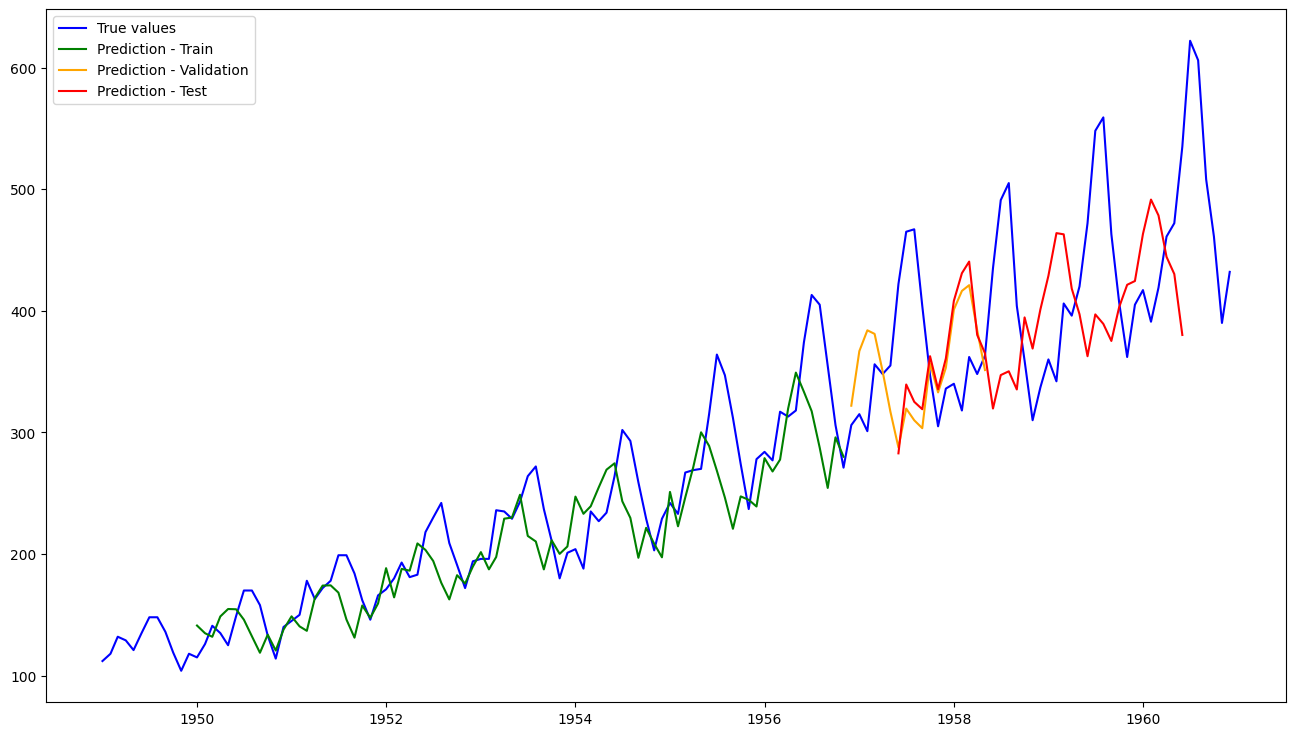


RMSE TEST: 59.78667406991272


In [11]:
backtests(best_model)

**#9 Summary**

In the task, a model was created to predict the number of airline passengers using neural networks (RNN, LSTM, GRU). The data was split into training, validation, and test sets, and the model was trained on various combinations of hyperparameters (look_back and the number of units in the layer). The best model was selected based on the lowest RMSE on the validation set. Finally, predictions were visualized, and RMSE for the test set was calculated to evaluate the model's performance.







